In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

In [3]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=1e-2):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

Reseting datasets values with new specs


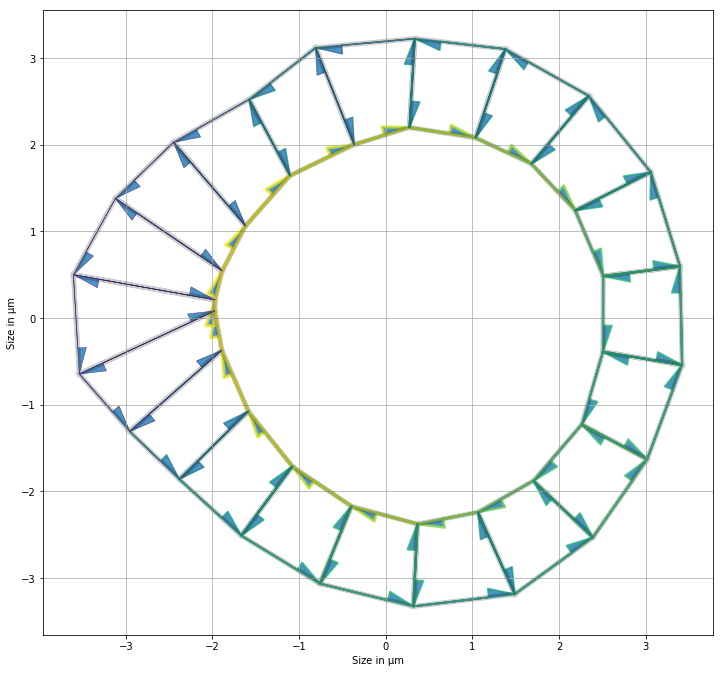

In [4]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93693569e8>)

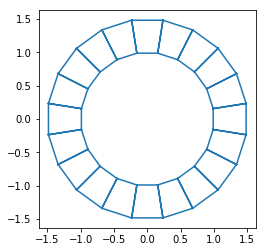

In [5]:
sym_org = generate_ring(nf, r_in, r_out)
geom.update_all(sym_org)
quick_edge_draw(sym_org)

In [6]:
#selectionner les coordonnées des vertex apicaux
api_vertex = organo.vert_df.loc[organo.apical_verts, ('x', 'y')]
#centre des cellules
cell_centers = organo.face_df.loc[:, ('x', 'y')]

In [7]:
api_vertex.head()

,x,y
vert,,
0,2.505490,-0.389034
1,2.260841,-1.227482
2,1.704032,-1.876593
3,1.063769,-2.239495
4,0.366279,-2.375904


In [8]:
cell_centers.head()

,x,y
face,,
0,2.800145,-0.947523
1,2.342210,-1.816765
2,1.660884,-2.458632
3,0.808607,-2.782078
4,-0.118299,-2.734780


## Matrice et constante de l'inférence de forces

In [50]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

Calcul des paramètres dans l'organoïde régulier

In [10]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

Calcul du "coefficient de polarisation", avec le 

In [12]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    parrallel_edges = (organo.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo.edge_df.face == cell]).values
    apical_middle = organo.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.7804046 , 1.80896929, 1.97237282, 1.95819428, 1.91354156,
       1.9663041 , 2.13011039, 2.5651894 , 3.14946586, 3.26946007,
       3.11867021, 2.77275355, 2.28573431, 2.22316687, 2.20358018,
       2.11542926, 2.09600265, 1.99059355, 1.86836   , 1.82366071])

In [41]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.6298519 , 0.58552087, 0.54554701, 0.5578145 , 0.57129197,
       0.57944321, 0.56423776, 0.59851501, 0.78701856, 0.81035332,
       0.76745019, 0.70391654, 0.6724686 , 0.63208301, 0.60714558,
       0.60834998, 0.59372321, 0.59204298, 0.62304487, 0.62635186])

In [ ]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
print(avg_cste)
avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_prec = np.squeeze(np.argwhere(organo.edge_df.face.values == (i-1)%organo.Nf))
    index[-1] = index_prec[-2]
    #index[-1] = 40
    print(index)
    i_cell_line[index] = 1
    print(i_cell_line)
    #matrix = np.vstack((matrix, i_cell_line))
#constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

In [87]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}
start_copy = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/14_03_eq_t_per_cell_new_criteria.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

11.005773357470062 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005773312886458 [0.13482568 0.16408835 0.14749541 0.09187403 0.05164239 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331112 0.17279911
 0.21220916 0.39494081 0.56660618 0.5696623  0.29027213 0.14558082
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005772877544052 [0.13482569 0.16408834 0.1474954  0.09187403 0.05164241 0.18043359
 0.35613357 0.55623936 0.68585684 0.53580537 0.32423468 0.50618389
 0.55841779 0.40766236 0.30639722 0.14941919 0.05682567 0.08481849
 0.15925171 0.18346393 0.03651568 0.10330665 0.19331112 0.17279908
 0.21220918 0.39494079 0.56660616 0.56966228 0.29027211 0.1455808
 0.21029734 0.2109562  0.42316041 0.55236224 0.42734523 0.28779647
 0.17054577 0.18135045 0.15452921 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

11.005773370264382 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623939 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841782 0.40766238 0.30639724 0.14941919 0.05682565 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558082
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779648
 0.1705458  0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005773371720169 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925173 0.18346394 0.03651568 0.10330665 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005773315726527 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585687 0.53580539 0.3242347  0.5061839
 0.55841781 0.40766237 0.30639723 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331112 0.17279909
 0.21220919 0.39494081 0.56660617 0.56966229 0.29027213 0.14558082
 0.21029734 0.21095621 0.42316042 0.55236227 0.42734523 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.00577334910761 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766237 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331112 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734523 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

11.005773392735524 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.08481851
 0.15925173 0.18346393 0.03651569 0.10330666 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135047 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

11.005771969970926 [0.13482572 0.16408834 0.1474954  0.09187408 0.05164221 0.18043367
 0.35613354 0.55623929 0.68585678 0.53580539 0.32423469 0.5061839
 0.55841774 0.40766233 0.30639716 0.14941916 0.05682567 0.08481849
 0.15925169 0.18346395 0.03651568 0.10330665 0.19331111 0.17279906
 0.21220932 0.39494048 0.56660609 0.56966225 0.29027211 0.14558078
 0.2102973  0.2109562  0.4231604  0.55236216 0.42734521 0.28779643
 0.17054576 0.18135044 0.1545292  0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

11.00577949739382 [0.13482559 0.16408842 0.14749567 0.09187431 0.05164241 0.18043359
 0.35613387 0.55623964 0.68585727 0.53580553 0.32423475 0.506184
 0.55841825 0.40766261 0.30639748 0.14941924 0.05682549 0.08481871
 0.159252   0.18346399 0.03651575 0.10330668 0.19331123 0.1727993
 0.2122093  0.39494101 0.56660645 0.56966258 0.29027235 0.14558088
 0.21029741 0.21095608 0.42316062 0.55236288 0.42734538 0.28779677
 0.17054588 0.1813506  0.15452937 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

11.005772273606983 [0.1348257  0.16408834 0.14749539 0.09187402 0.05164241 0.18043357
 0.35613353 0.55623932 0.6858568  0.53580536 0.32423465 0.50618388
 0.55841775 0.40766234 0.3063972  0.14941919 0.05682571 0.08481841
 0.15925178 0.18346399 0.03651562 0.10330665 0.19331111 0.17279907
 0.21220916 0.39494076 0.56660611 0.56966224 0.29027209 0.14558082
 0.21029733 0.2109562  0.4231604  0.5523622  0.42734521 0.28779643
 0.17054564 0.18135046 0.15452927 0.06115618 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

11.005773357470062 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005773357470062 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005773357470062 [0.13482568 0.16408835 0.14749542 0.09187404 0.05164241 0.18043359
 0.35613359 0.55623938 0.68585688 0.5358054  0.3242347  0.5061839
 0.55841781 0.40766238 0.30639724 0.14941919 0.05682566 0.0848185
 0.15925172 0.18346394 0.03651568 0.10330665 0.19331113 0.17279909
 0.21220919 0.39494081 0.56660618 0.5696623  0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236228 0.42734524 0.28779649
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.005773118467435 [0.13482568 0.16408834 0.14749541 0.09187404 0.05164241 0.18043359
 0.35613358 0.55623937 0.68585686 0.53580539 0.32423469 0.50618389
 0.5584178  0.40766237 0.30639723 0.14941919 0.05682566 0.0848185
 0.15925171 0.18346393 0.03651568 0.10330666 0.19331111 0.17279908
 0.21220918 0.3949408  0.56660616 0.56966229 0.29027213 0.14558083
 0.21029734 0.21095621 0.42316042 0.55236226 0.42734523 0.28779648
 0.17054578 0.18135046 0.15452922 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

11.005777019268812 [0.1348256  0.16408838 0.14749557 0.09187421 0.05164242 0.18043359
 0.35613379 0.55623955 0.68585712 0.53580542 0.32423472 0.50618385
 0.558418   0.40766249 0.30639741 0.14941923 0.05682554 0.08481862
 0.1592519  0.18346395 0.03651571 0.10330667 0.19331119 0.17279923
 0.21220926 0.39494095 0.56660636 0.56966249 0.29027224 0.14558095
 0.21029748 0.21095623 0.42316046 0.55236261 0.42734529 0.28779668
 0.17054585 0.18135055 0.15452931 0.06115615 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

11.005774108743186 [0.13482567 0.16408836 0.14749545 0.09187407 0.05164241 0.18043359
 0.35613362 0.55623942 0.68585693 0.53580541 0.3242347  0.50618389
 0.55841785 0.40766239 0.30639727 0.1494192  0.05682564 0.08481853
 0.15925176 0.18346394 0.03651569 0.10330666 0.19331114 0.17279912
 0.2122092  0.39494084 0.56660621 0.56966234 0.29027215 0.14558085
 0.21029737 0.21095622 0.42316043 0.55236234 0.42734526 0.28779653
 0.17054579 0.18135048 0.15452924 0.06115616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

11.00577239477261 [0.1348257  0.16408833 0.14749538 0.09187401 0.05164241 0.18043359
 0.35613355 0.55623934 0.68585681 0.53580538 0.32423468 0.5061839
 0.55841776 0.40766235 0.3063972  0.14941919 0.05682568 0.08481847
 0.15925168 0.18346393 0.03651567 0.10330665 0.19331111 0.17279906
 0.21220916 0.39494077 0.56660613 0.56966226 0.2902721  0.14558081
 0.21029732 0.2109562  0.42316041 0.5523622  0.42734521 0.28779645
 0.17054576 0.18135044 0.1545292  0.06115615 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

11.74807201254243 [1.36566711e-01 1.60829128e-01 3.00356348e-01 3.31175394e-01
 1.27942541e-01 2.68477533e-01 4.28319550e-01 4.26243775e-01
 3.79876536e-01 3.49851936e-01 4.64128503e-01 2.54822678e-01
 4.58611822e-01 4.05487000e-01 3.67212615e-01 1.97566039e-01
 1.54207735e-01 1.29894263e-01 3.33209378e-01 1.80251794e-01
 1.00530905e-01 1.23412050e-01 2.08194491e-01 2.73708816e-01
 2.76670358e-01 3.77552901e-01 2.60077161e-01 5.15419955e-01
 4.07653406e-01 1.74270065e-01 5.26765587e-01 2.26203980e-01
 2.03338697e-01 5.26071427e-01 2.85572432e-01 3.35103795e-01
 2.37971462e-01 4.43364218e-01 2.78400511e-01 1.10318838e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

10.953458258711358 [1.12432248e-01 1.33680977e-01 2.55958540e-01 3.41485258e-01
 1.43212820e-01 2.81210189e-01 4.24518114e-01 3.64631587e-01
 3.18189656e-01 2.25395438e-01 3.35400657e-01 2.00238138e-01
 3.85094160e-01 3.65298979e-01 3.70314499e-01 2.06532510e-01
 1.79810029e-01 1.40817602e-01 3.26558479e-01 1.54662168e-01
 1.42539178e-01 8.38092512e-02 2.34852583e-01 2.41167277e-01
 2.66967892e-01 4.22002484e-01 1.76702465e-01 5.20809329e-01
 3.64479377e-01 1.96222011e-01 4.09702940e-01 1.80627077e-01
 1.69261241e-01 5.02265781e-01 2.52896777e-01 3.51506136e-01
 2.52375449e-01 4.77517092e-01 3.18959619e-01 1.20912572e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.324450551473493 [1.17508491e-01 1.47751442e-01 2.79952230e-01 3.35261401e-01
 1.32246906e-01 2.71265085e-01 4.37984245e-01 3.89628516e-01
 3.42139706e-01 2.79138549e-01 3.92524125e-01 2.32306915e-01
 4.20064718e-01 3.89583061e-01 3.73836611e-01 1.88846125e-01
 1.68041855e-01 1.49688227e-01 3.38283183e-01 1.83530937e-01
 1.18137904e-01 1.03544764e-01 2.19217603e-01 2.56384701e-01
 2.68282662e-01 3.96992434e-01 2.37217207e-01 5.13781255e-01
 3.87383637e-01 1.82442394e-01 4.61324244e-01 1.99614839e-01
 1.84156026e-01 5.13038390e-01 2.70318292e-01 3.38463223e-01
 2.39109997e-01 4.51673665e-01 3.01911434e-01 1.09433874e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

12.064359284688262 [1.47154508e-01 1.75567205e-01 3.09365743e-01 3.54119758e-01
 1.34614680e-01 2.83273479e-01 4.38598346e-01 4.22544986e-01
 3.76797029e-01 3.34379036e-01 4.47406068e-01 2.53610223e-01
 4.52615211e-01 4.05026803e-01 3.78027442e-01 2.01612927e-01
 1.68706074e-01 1.43135819e-01 3.55148823e-01 2.08609696e-01
 1.24977108e-01 1.22528519e-01 2.24268117e-01 2.80294864e-01
 2.87944484e-01 3.93615378e-01 2.52280349e-01 5.31045974e-01
 4.09691751e-01 1.79712507e-01 5.10736928e-01 2.26845489e-01
 1.97995204e-01 5.47480118e-01 2.92972185e-01 3.51139251e-01
 2.44018412e-01 4.74245315e-01 3.03539337e-01 1.16274460e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

10.877514168004037 [1.19094834e-01 1.33228454e-01 2.49119470e-01 3.46762269e-01
 1.54002390e-01 2.85175058e-01 4.20950206e-01 3.59378989e-01
 3.08341148e-01 2.06564904e-01 3.14738003e-01 1.85313198e-01
 3.75925052e-01 3.58178995e-01 3.70420501e-01 2.16926910e-01
 1.85336661e-01 1.31127999e-01 3.25091362e-01 1.44430246e-01
 1.52739419e-01 7.67274619e-02 2.44511483e-01 2.36986361e-01
 2.70318049e-01 4.30481643e-01 1.43020700e-01 5.25964084e-01
 3.57076445e-01 1.99319874e-01 3.95217488e-01 1.76156413e-01
 1.58528087e-01 4.98171223e-01 2.46049023e-01 3.58634511e-01
 2.60152112e-01 4.93665370e-01 3.29383571e-01 1.31864523e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.860373879859772 [1.33149764e-01 1.57389973e-01 3.01096197e-01 3.33324587e-01
 1.20668799e-01 2.71769876e-01 4.33824407e-01 4.29715702e-01
 3.84534207e-01 3.51145097e-01 4.66883179e-01 2.56640073e-01
 4.58452077e-01 4.18395074e-01 3.67716815e-01 2.01447051e-01
 1.53096994e-01 1.29261062e-01 3.31692810e-01 1.83376054e-01
 9.84233358e-02 1.22985543e-01 2.07725185e-01 2.77179402e-01
 2.81899273e-01 3.88555564e-01 2.70629718e-01 5.25106398e-01
 4.16264520e-01 1.82646018e-01 5.33856888e-01 2.25729008e-01
 2.08900584e-01 5.30859933e-01 2.84718121e-01 3.37845822e-01
 2.41629763e-01 4.53501405e-01 2.78992503e-01 1.06905419e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.887622929997747 [1.41590504e-01 1.71856129e-01 3.07264428e-01 3.47126236e-01
 1.37825685e-01 2.73952545e-01 4.33118082e-01 4.20343694e-01
 3.74347359e-01 3.38272287e-01 4.50973759e-01 2.60035871e-01
 4.47881961e-01 4.00667946e-01 3.72128755e-01 1.99714486e-01
 1.63801598e-01 1.38435003e-01 3.46004246e-01 2.04495524e-01
 1.18341323e-01 1.21354522e-01 2.18647040e-01 2.76303178e-01
 2.80201256e-01 3.80133301e-01 2.48380926e-01 5.20677508e-01
 4.02829403e-01 1.70362277e-01 5.12469015e-01 2.27425078e-01
 1.96218321e-01 5.37598216e-01 2.91837402e-01 3.44668203e-01
 2.39555663e-01 4.59197064e-01 2.94770922e-01 1.14376535e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.725313021232962 [1.31996919e-01 1.56156221e-01 2.97331635e-01 3.29683430e-01
 1.22454595e-01 2.70125025e-01 4.27401829e-01 4.26361271e-01
 3.80630134e-01 3.45952115e-01 4.61107693e-01 2.54316391e-01
 4.54353827e-01 4.11371174e-01 3.63996940e-01 2.01165110e-01
 1.52576748e-01 1.27048260e-01 3.28614645e-01 1.80478565e-01
 9.95006879e-02 1.21936780e-01 2.07347511e-01 2.73018387e-01
 2.77123625e-01 3.82953959e-01 2.63863134e-01 5.18285188e-01
 4.08982633e-01 1.77452181e-01 5.26954490e-01 2.23206719e-01
 2.05141425e-01 5.25457942e-01 2.83045836e-01 3.35558941e-01
 2.39139292e-01 4.45333724e-01 2.77225382e-01 1.08222978e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

12.08410506422619 [1.46525314e-01 1.76979885e-01 3.16410551e-01 3.45697038e-01
 1.34741477e-01 2.73504981e-01 4.36246373e-01 4.31815002e-01
 3.86661398e-01 3.61727448e-01 4.75288704e-01 2.69502108e-01
 4.64392742e-01 4.10357104e-01 3.73494742e-01 1.96300810e-01
 1.59750660e-01 1.39445821e-01 3.50366293e-01 2.08871043e-01
 1.10439412e-01 1.29900648e-01 2.14629259e-01 2.83345269e-01
 2.83127663e-01 3.73983981e-01 2.70164218e-01 5.21658237e-01
 4.13907749e-01 1.69152749e-01 5.34516136e-01 2.36524709e-01
 2.03972172e-01 5.43596998e-01 2.98406980e-01 3.42190837e-01
 2.38606824e-01 4.54036926e-01 2.89089039e-01 1.12336086e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.779050077070547 [1.39977795e-01 1.68181760e-01 3.01699958e-01 3.48223973e-01
 1.40303322e-01 2.73981450e-01 4.33027160e-01 4.12460875e-01
 3.67418986e-01 3.24646419e-01 4.37074978e-01 2.52153811e-01
 4.40259041e-01 3.93395236e-01 3.73580885e-01 1.99792047e-01
 1.67149730e-01 1.41179353e-01 3.44550596e-01 1.96550209e-01
 1.22534791e-01 1.16001727e-01 2.20503070e-01 2.72727641e-01
 2.78681808e-01 3.84248497e-01 2.37361914e-01 5.20759233e-01
 3.97232003e-01 1.71198934e-01 4.99302383e-01 2.23799432e-01
 1.92592186e-01 5.34279579e-01 2.87753890e-01 3.45857330e-01
 2.40262779e-01 4.63570026e-01 2.97540824e-01 1.14794767e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.628588042855588 [1.29005852e-01 1.61924074e-01 2.94001485e-01 3.45017164e-01
 1.37333948e-01 2.74255155e-01 4.37972913e-01 4.00532819e-01
 3.56639876e-01 3.04256220e-01 4.16722581e-01 2.43855815e-01
 4.31328064e-01 3.93264968e-01 3.76115652e-01 1.92576336e-01
 1.69201125e-01 1.48487528e-01 3.46383460e-01 1.98044931e-01
 1.22267009e-01 1.11299020e-01 2.21802571e-01 2.66312024e-01
 2.74952357e-01 3.90841877e-01 2.40528116e-01 5.19356651e-01
 3.94743790e-01 1.77525901e-01 4.79537836e-01 2.13075559e-01
 1.88117297e-01 5.27303773e-01 2.82389866e-01 3.44373319e-01
 2.39781579e-01 4.59561763e-01 3.02833339e-01 1.12624751e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.91065785214703 [1.42536961e-01 1.64713246e-01 3.03679225e-01 3.38868317e-01
 1.26828877e-01 2.75629791e-01 4.30124190e-01 4.29950525e-01
 3.83116852e-01 3.48534770e-01 4.63098379e-01 2.55029225e-01
 4.60708658e-01 4.09582653e-01 3.69145702e-01 2.03430443e-01
 1.57267400e-01 1.30827444e-01 3.38834729e-01 1.85642748e-01
 1.07495231e-01 1.24323102e-01 2.13052661e-01 2.77938584e-01
 2.83295923e-01 3.87506471e-01 2.59368650e-01 5.24250989e-01
 4.11616471e-01 1.78104095e-01 5.29812133e-01 2.27408118e-01
 2.04288696e-01 5.35291908e-01 2.87843889e-01 3.41777108e-01
 2.42065086e-01 4.57890231e-01 2.85361213e-01 1.11977478e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.935121517306182 [1.43284960e-01 1.73755170e-01 3.08284921e-01 3.49802025e-01
 1.37626749e-01 2.76630510e-01 4.35191881e-01 4.20127655e-01
 3.74024695e-01 3.37074190e-01 4.49619036e-01 2.59046321e-01
 4.47532264e-01 4.01423326e-01 3.74157178e-01 2.00031231e-01
 1.65462360e-01 1.40881447e-01 3.48517979e-01 2.07220524e-01
 1.20521952e-01 1.21066403e-01 2.20431691e-01 2.77398286e-01
 2.82271604e-01 3.83019061e-01 2.48119834e-01 5.23648126e-01
 4.04530274e-01 1.72979511e-01 5.08703959e-01 2.28345031e-01
 1.96087628e-01 5.40411423e-01 2.92212664e-01 3.46358328e-01
 2.40084898e-01 4.64453828e-01 2.97472503e-01 1.14870411e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.287442611930917 [1.17121470e-01 1.42732877e-01 2.71339767e-01 3.38058574e-01
 1.31520794e-01 2.79709294e-01 4.38927126e-01 3.85506522e-01
 3.37167391e-01 2.60558357e-01 3.73652773e-01 2.13607118e-01
 4.14819814e-01 3.87373519e-01 3.77296953e-01 1.92850740e-01
 1.73656034e-01 1.51183336e-01 3.37607546e-01 1.75425752e-01
 1.24946356e-01 9.84358514e-02 2.25375080e-01 2.53419908e-01
 2.71615000e-01 4.13615803e-01 2.26072905e-01 5.18630994e-01
 3.86882821e-01 1.91778303e-01 4.45356726e-01 1.91340725e-01
 1.82905872e-01 5.13687971e-01 2.63997670e-01 3.43559116e-01
 2.44964073e-01 4.64826623e-01 3.09550033e-01 1.13925342e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.878315989467055 [1.37808443e-01 1.62849936e-01 2.99253821e-01 3.38983496e-01
 1.24306541e-01 2.78744566e-01 4.28512194e-01 4.24172043e-01
 3.86833628e-01 3.42250922e-01 4.56942931e-01 2.48791548e-01
 4.55245604e-01 4.06970927e-01 3.72017095e-01 2.07140779e-01
 1.59450116e-01 1.28688609e-01 3.35131722e-01 1.76458788e-01
 1.10979660e-01 1.19743518e-01 2.15388138e-01 2.76330788e-01
 2.86491988e-01 3.95990449e-01 2.45503948e-01 5.30722563e-01
 4.10850564e-01 1.81733515e-01 5.28443139e-01 2.25927881e-01
 2.02796255e-01 5.33236545e-01 2.83953210e-01 3.45200458e-01
 2.46008642e-01 4.67008163e-01 2.85581469e-01 1.13431707e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.498298245559205 [1.23077468e-01 1.56775346e-01 2.87303966e-01 3.43201474e-01
 1.35373788e-01 2.75259828e-01 4.37970356e-01 3.93636596e-01
 3.48953062e-01 2.88618830e-01 4.01229758e-01 2.38893401e-01
 4.21712331e-01 3.90862425e-01 3.75939489e-01 1.92303295e-01
 1.70532943e-01 1.48844441e-01 3.43468324e-01 1.94968475e-01
 1.23546191e-01 1.06218170e-01 2.23175207e-01 2.61305158e-01
 2.72729312e-01 3.97081759e-01 2.33071517e-01 5.18155572e-01
 3.90332379e-01 1.82099883e-01 4.66445412e-01 2.05717693e-01
 1.85384492e-01 5.22017508e-01 2.76619314e-01 3.43893476e-01
 2.40966989e-01 4.59704376e-01 3.05736120e-01 1.12732442e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.498298245559205 [1.23077468e-01 1.56775346e-01 2.87303966e-01 3.43201474e-01
 1.35373788e-01 2.75259828e-01 4.37970356e-01 3.93636596e-01
 3.48953062e-01 2.88618830e-01 4.01229758e-01 2.38893401e-01
 4.21712331e-01 3.90862425e-01 3.75939489e-01 1.92303295e-01
 1.70532943e-01 1.48844441e-01 3.43468324e-01 1.94968475e-01
 1.23546191e-01 1.06218170e-01 2.23175207e-01 2.61305158e-01
 2.72729312e-01 3.97081759e-01 2.33071517e-01 5.18155572e-01
 3.90332379e-01 1.82099883e-01 4.66445412e-01 2.05717693e-01
 1.85384492e-01 5.22017508e-01 2.76619314e-01 3.43893476e-01
 2.40966989e-01 4.59704376e-01 3.05736120e-01 1.12732442e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.498298245559205 [1.23077468e-01 1.56775346e-01 2.87303966e-01 3.43201474e-01
 1.35373788e-01 2.75259828e-01 4.37970356e-01 3.93636596e-01
 3.48953062e-01 2.88618830e-01 4.01229758e-01 2.38893401e-01
 4.21712331e-01 3.90862425e-01 3.75939489e-01 1.92303295e-01
 1.70532943e-01 1.48844441e-01 3.43468324e-01 1.94968475e-01
 1.23546191e-01 1.06218170e-01 2.23175207e-01 2.61305158e-01
 2.72729312e-01 3.97081759e-01 2.33071517e-01 5.18155572e-01
 3.90332379e-01 1.82099883e-01 4.66445412e-01 2.05717693e-01
 1.85384492e-01 5.22017508e-01 2.76619314e-01 3.43893476e-01
 2.40966989e-01 4.59704376e-01 3.05736120e-01 1.12732442e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.498298245559205 [1.23077468e-01 1.56775346e-01 2.87303966e-01 3.43201474e-01
 1.35373788e-01 2.75259828e-01 4.37970356e-01 3.93636596e-01
 3.48953062e-01 2.88618830e-01 4.01229758e-01 2.38893401e-01
 4.21712331e-01 3.90862425e-01 3.75939489e-01 1.92303295e-01
 1.70532943e-01 1.48844441e-01 3.43468324e-01 1.94968475e-01
 1.23546191e-01 1.06218170e-01 2.23175207e-01 2.61305158e-01
 2.72729312e-01 3.97081759e-01 2.33071517e-01 5.18155572e-01
 3.90332379e-01 1.82099883e-01 4.66445412e-01 2.05717693e-01
 1.85384492e-01 5.22017508e-01 2.76619314e-01 3.43893476e-01
 2.40966989e-01 4.59704376e-01 3.05736120e-01 1.12732442e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.498298245559205 [1.23077468e-01 1.56775346e-01 2.87303966e-01 3.43201474e-01
 1.35373788e-01 2.75259828e-01 4.37970356e-01 3.93636596e-01
 3.48953062e-01 2.88618830e-01 4.01229758e-01 2.38893401e-01
 4.21712331e-01 3.90862425e-01 3.75939489e-01 1.92303295e-01
 1.70532943e-01 1.48844441e-01 3.43468324e-01 1.94968475e-01
 1.23546191e-01 1.06218170e-01 2.23175207e-01 2.61305158e-01
 2.72729312e-01 3.97081759e-01 2.33071517e-01 5.18155572e-01
 3.90332379e-01 1.82099883e-01 4.66445412e-01 2.05717693e-01
 1.85384492e-01 5.22017508e-01 2.76619314e-01 3.43893476e-01
 2.40966989e-01 4.59704376e-01 3.05736120e-01 1.12732442e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.984539911718205 [1.42458960e-01 1.71060483e-01 3.07507914e-01 3.48075851e-01
 1.31179067e-01 2.79543928e-01 4.35104065e-01 4.24835939e-01
 3.81663065e-01 3.38504354e-01 4.52395721e-01 2.57556343e-01
 4.51743193e-01 4.07605621e-01 3.74307530e-01 2.01801639e-01
 1.63991638e-01 1.36995790e-01 3.47859013e-01 2.01601239e-01
 1.17940388e-01 1.22767607e-01 2.19483655e-01 2.79047901e-01
 2.85494416e-01 3.90595169e-01 2.53029882e-01 5.26454098e-01
 4.09777902e-01 1.77234585e-01 5.18773405e-01 2.26520500e-01
 2.00521112e-01 5.41849356e-01 2.90765318e-01 3.46870222e-01
 2.43066640e-01 4.66475367e-01 2.96018967e-01 1.13622393e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.479572239741515 [1.25001103e-01 1.53634493e-01 2.83234059e-01 3.42802537e-01
 1.34557955e-01 2.78233663e-01 4.37875747e-01 3.93697737e-01
 3.47887687e-01 2.82645490e-01 3.95121414e-01 2.28864790e-01
 4.24194509e-01 3.89656328e-01 3.76919371e-01 1.93601924e-01
 1.71954492e-01 1.49524616e-01 3.43408296e-01 1.86707663e-01
 1.24856289e-01 1.05265075e-01 2.24489557e-01 2.60430065e-01
 2.74051838e-01 4.02595649e-01 2.31924875e-01 5.19832206e-01
 3.91032431e-01 1.84470349e-01 4.63239733e-01 2.01672660e-01
 1.85344746e-01 5.21866436e-01 2.73993850e-01 3.45082779e-01
 2.42657825e-01 4.63712486e-01 3.07151374e-01 1.13938465e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.6647585703294 [1.32479207e-01 1.63904849e-01 2.94355425e-01 3.45495836e-01
 1.35729492e-01 2.77454439e-01 4.36816714e-01 4.02404847e-01
 3.57094568e-01 3.04523636e-01 4.16835833e-01 2.43143832e-01
 4.34652402e-01 3.93144610e-01 3.76089219e-01 1.93933205e-01
 1.69494248e-01 1.47388998e-01 3.48991196e-01 1.97990119e-01
 1.23306559e-01 1.12628535e-01 2.23417255e-01 2.66846120e-01
 2.76594077e-01 3.92029905e-01 2.41047517e-01 5.20919070e-01
 3.95138995e-01 1.78285856e-01 4.82526437e-01 2.11370567e-01
 1.88299230e-01 5.29376207e-01 2.82912217e-01 3.45539135e-01
 2.40489061e-01 4.60599913e-01 3.04710659e-01 1.14358901e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

11.73427911944841 [1.29962318e-01 1.58247841e-01 2.98331626e-01 3.32764606e-01
 1.21978569e-01 2.73254511e-01 4.29560126e-01 4.23356085e-01
 3.81002508e-01 3.40758769e-01 4.56151139e-01 2.58343998e-01
 4.47100825e-01 4.10951881e-01 3.66715850e-01 2.00620780e-01
 1.54867578e-01 1.30126285e-01 3.30108151e-01 1.86073348e-01
 1.02153563e-01 1.19497415e-01 2.08966144e-01 2.73132028e-01
 2.78039568e-01 3.85379090e-01 2.58713521e-01 5.17778093e-01
 4.08791407e-01 1.78396449e-01 5.19661573e-01 2.24318170e-01
 2.04383300e-01 5.26778062e-01 2.82823230e-01 3.36130728e-01
 2.38872479e-01 4.50053404e-01 2.80374150e-01 1.07320273e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.55471250259498 [1.21975510e-01 1.49895991e-01 2.92256760e-01 3.20171060e-01
 1.19934926e-01 2.64202027e-01 4.25703019e-01 4.21212902e-01
 3.80905668e-01 3.47406285e-01 4.62965980e-01 2.55435226e-01
 4.51912363e-01 4.08479327e-01 3.63895708e-01 1.95986701e-01
 1.48296575e-01 1.25518913e-01 3.19881147e-01 1.67155397e-01
 9.03816387e-02 1.19525850e-01 2.01372112e-01 2.68570116e-01
 2.71754053e-01 3.77962615e-01 2.63048295e-01 5.12037969e-01
 4.06756550e-01 1.77145171e-01 5.28266001e-01 2.22105938e-01
 2.05471653e-01 5.14476857e-01 2.78834992e-01 3.28967717e-01
 2.36612056e-01 4.33220180e-01 2.67830973e-01 1.04740602e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158411388 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762142262056 [6.76723771e-02 4.49074881e-02 1.05605062e-01 4.21222370e-01
 2.23485072e-01 2.44591155e-01 4.32236512e-01 2.70813326e-01
 3.78908348e-01 8.20228799e-02 1.34170429e-01 9.18273330e-02
 2.42681580e-01 3.13072880e-01 2.82578886e-01 2.99880516e-01
 3.78219408e-01 1.00315409e-01 2.89789908e-01 6.02092881e-02
 1.34019895e-01 4.71994667e-02 3.24175461e-01 8.69453474e-02
 2.69623088e-01 5.94143200e-01 1.25939567e-01 5.17002850e-01
 3.01054471e-01 2.33775888e-01 2.01437691e-01 1.24276895e-01
 1.71186420e-01 3.74324804e-01 2.77207366e-01 3.24366645e-01
 3.45730652e-01 4.34725844e-01 2.29712373e-01 1.34473363e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762248094922 [6.76723772e-02 4.49074917e-02 1.05605071e-01 4.21222388e-01
 2.23485080e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908376e-01 8.20228820e-02 1.34170437e-01 9.18273401e-02
 2.42681578e-01 3.13072880e-01 2.82578886e-01 2.99880518e-01
 3.78219411e-01 1.00315408e-01 2.89789911e-01 6.02092908e-02
 1.34019897e-01 4.71994629e-02 3.24175467e-01 8.69453478e-02
 2.69623089e-01 5.94143202e-01 1.25939563e-01 5.17002852e-01
 3.01054475e-01 2.33775888e-01 2.01437692e-01 1.24276896e-01
 1.71186422e-01 3.74324806e-01 2.77207370e-01 3.24366647e-01
 3.45730654e-01 4.34725842e-01 2.29712369e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762203703304 [6.76723780e-02 4.49074914e-02 1.05605070e-01 4.21222388e-01
 2.23485081e-01 2.44591156e-01 4.32236513e-01 2.70813327e-01
 3.78908350e-01 8.20228827e-02 1.34170430e-01 9.18273411e-02
 2.42681568e-01 3.13072877e-01 2.82578885e-01 2.99880517e-01
 3.78219412e-01 1.00315407e-01 2.89789910e-01 6.02092882e-02
 1.34019897e-01 4.71994628e-02 3.24175467e-01 8.69453480e-02
 2.69623089e-01 5.94143203e-01 1.25939560e-01 5.17002850e-01
 3.01054468e-01 2.33775887e-01 2.01437696e-01 1.24276886e-01
 1.71186443e-01 3.74324800e-01 2.77207367e-01 3.24366647e-01
 3.45730655e-01 4.34725843e-01 2.29712370e-01 1.34473363e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762244606864 [6.76723760e-02 4.49074901e-02 1.05605070e-01 4.21222385e-01
 2.23485078e-01 2.44591154e-01 4.32236512e-01 2.70813326e-01
 3.78908348e-01 8.20228812e-02 1.34170431e-01 9.18273402e-02
 2.42681577e-01 3.13072881e-01 2.82578885e-01 2.99880536e-01
 3.78219430e-01 1.00315405e-01 2.89789908e-01 6.02092908e-02
 1.34019895e-01 4.71994631e-02 3.24175465e-01 8.69453468e-02
 2.69623088e-01 5.94143201e-01 1.25939561e-01 5.17002849e-01
 3.01054469e-01 2.33775885e-01 2.01437691e-01 1.24276897e-01
 1.71186421e-01 3.74324804e-01 2.77207370e-01 3.24366660e-01
 3.45730671e-01 4.34725844e-01 2.29712369e-01 1.34473361e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762184968571 [6.76723916e-02 4.49074960e-02 1.05605070e-01 4.21222385e-01
 2.23485079e-01 2.44591156e-01 4.32236512e-01 2.70813326e-01
 3.78908348e-01 8.20228807e-02 1.34170430e-01 9.18273345e-02
 2.42681579e-01 3.13072880e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315409e-01 2.89789917e-01 6.02092774e-02
 1.34019885e-01 4.71994621e-02 3.24175464e-01 8.69453471e-02
 2.69623089e-01 5.94143203e-01 1.25939562e-01 5.17002850e-01
 3.01054470e-01 2.33775886e-01 2.01437691e-01 1.24276896e-01
 1.71186420e-01 3.74324804e-01 2.77207367e-01 3.24366645e-01
 3.45730652e-01 4.34725845e-01 2.29712367e-01 1.34473369e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158544732 [6.76723775e-02 4.49074885e-02 1.05605066e-01 4.21222387e-01
 2.23485078e-01 2.44591156e-01 4.32236512e-01 2.70813326e-01
 3.78908347e-01 8.20228796e-02 1.34170429e-01 9.18273328e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994641e-02 3.24175465e-01 8.69453450e-02
 2.69623091e-01 5.94143203e-01 1.25939564e-01 5.17002849e-01
 3.01054471e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762149295988 [6.76723779e-02 4.49074884e-02 1.05605066e-01 4.21222384e-01
 2.23485079e-01 2.44591156e-01 4.32236511e-01 2.70813324e-01
 3.78908342e-01 8.20228791e-02 1.34170429e-01 9.18273306e-02
 2.42681580e-01 3.13072879e-01 2.82578885e-01 2.99880515e-01
 3.78219407e-01 1.00315407e-01 2.89789907e-01 6.02092873e-02
 1.34019895e-01 4.71994637e-02 3.24175466e-01 8.69453472e-02
 2.69623091e-01 5.94143204e-01 1.25939564e-01 5.17002850e-01
 3.01054471e-01 2.33775888e-01 2.01437690e-01 1.24276895e-01
 1.71186419e-01 3.74324803e-01 2.77207365e-01 3.24366645e-01
 3.45730651e-01 4.34725844e-01 2.29712372e-01 1.34473363e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.71676215857275 [6.76723775e-02 4.49074891e-02 1.05605067e-01 4.21222385e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228798e-02 1.34170429e-01 9.18273320e-02
 2.42681580e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789908e-01 6.02092884e-02
 1.34019895e-01 4.71994635e-02 3.24175466e-01 8.69453473e-02
 2.69623090e-01 5.94143203e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437691e-01 1.24276900e-01
 1.71186415e-01 3.74324802e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712371e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

9.71676214190063 [6.76723780e-02 4.49074884e-02 1.05605066e-01 4.21222384e-01
 2.23485079e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228795e-02 1.34170429e-01 9.18273308e-02
 2.42681580e-01 3.13072879e-01 2.82578885e-01 2.99880512e-01
 3.78219404e-01 1.00315407e-01 2.89789907e-01 6.02092873e-02
 1.34019895e-01 4.71994637e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939564e-01 5.17002849e-01
 3.01054471e-01 2.33775888e-01 2.01437690e-01 1.24276895e-01
 1.71186419e-01 3.74324803e-01 2.77207366e-01 3.24366642e-01
 3.45730645e-01 4.34725844e-01 2.29712372e-01 1.34473363e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

9.716762167040843 [6.76723757e-02 4.49074895e-02 1.05605067e-01 4.21222385e-01
 2.23485078e-01 2.44591156e-01 4.32236512e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273331e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789908e-01 6.02092915e-02
 1.34019897e-01 4.71994632e-02 3.24175466e-01 8.69453473e-02
 2.69623090e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054471e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725844e-01 2.29712371e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762157061035 [6.76723777e-02 4.49074889e-02 1.05605067e-01 4.21222384e-01
 2.23485079e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228796e-02 1.34170429e-01 9.18273325e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092882e-02
 1.34019895e-01 4.71994631e-02 3.24175466e-01 8.69453486e-02
 2.69623090e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712371e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762154655395 [6.76723777e-02 4.49074887e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813326e-01
 3.78908346e-01 8.20228797e-02 1.34170429e-01 9.18273320e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315407e-01 2.89789907e-01 6.02092879e-02
 1.34019895e-01 4.71994637e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002848e-01
 3.01054471e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762157186148 [6.76723777e-02 4.49074887e-02 1.05605067e-01 4.21222384e-01
 2.23485079e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228799e-02 1.34170429e-01 9.18273325e-02
 2.42681580e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315407e-01 2.89789907e-01 6.02092877e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054471e-01 2.33775887e-01 2.01437690e-01 1.24276893e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.71676215801509 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

9.716762157286228 [6.76723775e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228796e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092880e-02
 1.34019895e-01 4.71994637e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158411388 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158411388 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158411388 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158411388 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158411388 [6.76723776e-02 4.49074888e-02 1.05605067e-01 4.21222384e-01
 2.23485078e-01 2.44591156e-01 4.32236511e-01 2.70813325e-01
 3.78908347e-01 8.20228797e-02 1.34170429e-01 9.18273324e-02
 2.42681579e-01 3.13072879e-01 2.82578885e-01 2.99880516e-01
 3.78219408e-01 1.00315408e-01 2.89789907e-01 6.02092881e-02
 1.34019895e-01 4.71994636e-02 3.24175466e-01 8.69453473e-02
 2.69623091e-01 5.94143204e-01 1.25939563e-01 5.17002849e-01
 3.01054470e-01 2.33775887e-01 2.01437690e-01 1.24276895e-01
 1.71186420e-01 3.74324803e-01 2.77207366e-01 3.24366645e-01
 3.45730651e-01 4.34725843e-01 2.29712372e-01 1.34473362e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762286897032 [6.76723904e-02 4.49074844e-02 1.05605056e-01 4.21222396e-01
 2.23485091e-01 2.44591164e-01 4.32236512e-01 2.70813327e-01
 3.78908351e-01 8.20228789e-02 1.34170425e-01 9.18272824e-02
 2.42681605e-01 3.13072878e-01 2.82578889e-01 2.99880515e-01
 3.78219408e-01 1.00315396e-01 2.89789900e-01 6.02092642e-02
 1.34019897e-01 4.71994663e-02 3.24175476e-01 8.69453505e-02
 2.69623103e-01 5.94143225e-01 1.25939577e-01 5.17002860e-01
 3.01054477e-01 2.33775904e-01 2.01437696e-01 1.24276887e-01
 1.71186418e-01 3.74324805e-01 2.77207362e-01 3.24366652e-01
 3.45730656e-01 4.34725875e-01 2.29712384e-01 1.34473375e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762158959204 [6.76723817e-02 4.49074868e-02 1.05605061e-01 4.21222384e-01
 2.23485081e-01 2.44591159e-01 4.32236509e-01 2.70813324e-01
 3.78908343e-01 8.20228814e-02 1.34170427e-01 9.18273113e-02
 2.42681590e-01 3.13072876e-01 2.82578886e-01 2.99880514e-01
 3.78219408e-01 1.00315402e-01 2.89789904e-01 6.02092745e-02
 1.34019897e-01 4.71994642e-02 3.24175468e-01 8.69453484e-02
 2.69623095e-01 5.94143209e-01 1.25939565e-01 5.17002855e-01
 3.01054474e-01 2.33775890e-01 2.01437693e-01 1.24276891e-01
 1.71186419e-01 3.74324802e-01 2.77207364e-01 3.24366647e-01
 3.45730652e-01 4.34725851e-01 2.29712375e-01 1.34473366e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762185063285 [6.76723695e-02 4.49074901e-02 1.05605076e-01 4.21222385e-01
 2.23485070e-01 2.44591152e-01 4.32236519e-01 2.70813325e-01
 3.78908343e-01 8.20228711e-02 1.34170428e-01 9.18273704e-02
 2.42681556e-01 3.13072888e-01 2.82578885e-01 2.99880520e-01
 3.78219406e-01 1.00315421e-01 2.89789915e-01 6.02093164e-02
 1.34019890e-01 4.71994645e-02 3.24175464e-01 8.69453438e-02
 2.69623085e-01 5.94143201e-01 1.25939562e-01 5.17002850e-01
 3.01054475e-01 2.33775882e-01 2.01437682e-01 1.24276904e-01
 1.71186425e-01 3.74324807e-01 2.77207367e-01 3.24366639e-01
 3.45730648e-01 4.34725832e-01 2.29712372e-01 1.34473356e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.716762249512197 [6.76723884e-02 4.49074848e-02 1.05605057e-01 4.21222389e-01
 2.23485088e-01 2.44591163e-01 4.32236512e-01 2.70813327e-01
 3.78908350e-01 8.20228791e-02 1.34170426e-01 9.18272893e-02
 2.42681600e-01 3.13072877e-01 2.82578887e-01 2.99880510e-01
 3.78219401e-01 1.00315397e-01 2.89789900e-01 6.02092679e-02
 1.34019897e-01 4.71994658e-02 3.24175473e-01 8.69453513e-02
 2.69623105e-01 5.94143222e-01 1.25939574e-01 5.17002858e-01
 3.01054476e-01 2.33775901e-01 2.01437695e-01 1.24276888e-01
 1.71186418e-01 3.74324805e-01 2.77207362e-01 3.24366655e-01
 3.45730659e-01 4.34725868e-01 2.29712381e-01 1.34473373e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.71676227777627 [6.76723825e-02 4.49074873e-02 1.05605061e-01 4.21222391e-01
 2.23485086e-01 2.44591161e-01 4.32236513e-01 2.70813327e-01
 3.78908352e-01 8.20228804e-02 1.34170429e-01 9.18273019e-02
 2.42681596e-01 3.13072878e-01 2.82578888e-01 2.99880517e-01
 3.78219410e-01 1.00315400e-01 2.89789904e-01 6.02092764e-02
 1.34019893e-01 4.71994655e-02 3.24175472e-01 8.69453511e-02
 2.69623102e-01 5.94143219e-01 1.25939571e-01 5.17002858e-01
 3.01054474e-01 2.33775899e-01 2.01437697e-01 1.24276890e-01
 1.71186420e-01 3.74324806e-01 2.77207365e-01 3.24366651e-01
 3.45730656e-01 4.34725865e-01 2.29712380e-01 1.34473374e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

8.892799582233 [4.95889875e-02 8.44835690e-02 1.61143667e-01 3.58935597e-01
 2.17402087e-01 2.60624779e-01 3.92905370e-01 2.84206492e-01
 4.09496669e-01 1.02777561e-01 9.16882070e-02 1.21959343e-01
 2.11909396e-01 2.99898151e-01 2.82471468e-01 2.71747808e-01
 3.13696858e-01 9.83684127e-02 2.84880392e-01 8.17797454e-02
 1.31454007e-01 2.03885918e-02 2.73483224e-01 1.16458760e-01
 2.06297767e-01 4.85667523e-01 9.39566350e-02 4.49359380e-01
 2.48732087e-01 2.21491861e-01 1.14627244e-01 1.48336857e-01
 1.84872418e-01 3.40261533e-01 2.85001264e-01 2.64930939e-01
 3.51540343e-01 3.21438073e-01 1.30361301e-01 1.23096774e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000000

8.892813691878043 [4.95891557e-02 8.44840489e-02 1.61144294e-01 3.58937516e-01
 2.17403546e-01 2.60624628e-01 3.92905785e-01 2.84205550e-01
 4.09498017e-01 1.02776901e-01 9.16870995e-02 1.21959289e-01
 2.11908702e-01 2.99896895e-01 2.82472148e-01 2.71749134e-01
 3.13697566e-01 9.83673222e-02 2.84881193e-01 8.17790225e-02
 1.31455688e-01 2.03887356e-02 2.73484275e-01 1.16458868e-01
 2.06298299e-01 4.85669093e-01 9.39558418e-02 4.49360623e-01
 2.48731475e-01 2.21491607e-01 1.14626850e-01 1.48337788e-01
 1.84872177e-01 3.40262050e-01 2.85002171e-01 2.64932106e-01
 3.51540931e-01 3.21439801e-01 1.30361928e-01 1.23097127e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.893740777649448 [4.95979055e-02 8.45177850e-02 1.61178989e-01 3.58983209e-01
 2.17418762e-01 2.60635389e-01 3.92925768e-01 2.84222712e-01
 4.09564466e-01 1.02789603e-01 9.17075437e-02 1.21973144e-01
 2.11923233e-01 2.99898048e-01 2.82484383e-01 2.71771528e-01
 3.13741705e-01 9.83637414e-02 2.84926951e-01 8.18030482e-02
 1.31486229e-01 2.03728173e-02 2.73508297e-01 1.16481230e-01
 2.06318089e-01 4.85708542e-01 9.39701957e-02 4.49395349e-01
 2.48746627e-01 2.21520707e-01 1.14643470e-01 1.48364912e-01
 1.84899787e-01 3.40302111e-01 2.85042620e-01 2.64960722e-01
 3.51592926e-01 3.21471365e-01 1.30352408e-01 1.23096018e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892777187334937 [4.95888259e-02 8.44828538e-02 1.61142806e-01 3.58934481e-01
 2.17401734e-01 2.60624798e-01 3.92904626e-01 2.84205903e-01
 4.09495293e-01 1.02777403e-01 9.16878587e-02 1.21959133e-01
 2.11909001e-01 2.99897889e-01 2.82471045e-01 2.71747356e-01
 3.13695834e-01 9.83682028e-02 2.84879204e-01 8.17789034e-02
 1.31453366e-01 2.03888733e-02 2.73482675e-01 1.16458242e-01
 2.06297243e-01 4.85666529e-01 9.39562641e-02 4.49358462e-01
 2.48731630e-01 2.21491124e-01 1.14626860e-01 1.48336360e-01
 1.84871788e-01 3.40260552e-01 2.85000403e-01 2.64930420e-01
 3.51539251e-01 3.21437270e-01 1.30361399e-01 1.23096882e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892792448042265 [4.95889977e-02 8.44833555e-02 1.61143501e-01 3.58936475e-01
 2.17403221e-01 2.60624620e-01 3.92905103e-01 2.84204992e-01
 4.09496701e-01 1.02776750e-01 9.16867518e-02 1.21959073e-01
 2.11908334e-01 2.99896649e-01 2.82471768e-01 2.71748710e-01
 3.13696588e-01 9.83671377e-02 2.84880047e-01 8.17782294e-02
 1.31455090e-01 2.03890005e-02 2.73483748e-01 1.16458380e-01
 2.06297811e-01 4.85668147e-01 9.39554819e-02 4.49359765e-01
 2.48731044e-01 2.21490909e-01 1.14626486e-01 1.48337310e-01
 1.84871572e-01 3.40261124e-01 2.85001338e-01 2.64931608e-01
 3.51539889e-01 3.21439038e-01 1.30362044e-01 1.23097217e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.89273273574485 [4.95884987e-02 8.44814162e-02 1.61141130e-01 3.58932279e-01
 2.17401016e-01 2.60624849e-01 3.92903131e-01 2.84204733e-01
 4.09492571e-01 1.02777087e-01 9.16871658e-02 1.21958694e-01
 2.11908236e-01 2.99897375e-01 2.82470225e-01 2.71746476e-01
 3.13693801e-01 9.83677725e-02 2.84876850e-01 8.17772076e-02
 1.31452118e-01 2.03894144e-02 2.73481576e-01 1.16457227e-01
 2.06296212e-01 4.85664569e-01 9.39555229e-02 4.49356635e-01
 2.48730711e-01 2.21489657e-01 1.14626110e-01 1.48335358e-01
 1.84870529e-01 3.40258625e-01 2.84998652e-01 2.64929406e-01
 3.51537093e-01 3.21435678e-01 1.30361602e-01 1.23097082e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

8.892755207084958 [4.95886650e-02 8.44821419e-02 1.61141979e-01 3.58933392e-01
 2.17401376e-01 2.60624822e-01 3.92903885e-01 2.84205325e-01
 4.09493948e-01 1.02777246e-01 9.16875165e-02 1.21958914e-01
 2.11908626e-01 2.99897637e-01 2.82470644e-01 2.71746923e-01
 3.13694828e-01 9.83679900e-02 2.84878041e-01 8.17780642e-02
 1.31452751e-01 2.03891384e-02 2.73482130e-01 1.16457740e-01
 2.06296734e-01 4.85665556e-01 9.39559007e-02 4.49357557e-01
 2.48731174e-01 2.21490399e-01 1.14626490e-01 1.48335863e-01
 1.84871164e-01 3.40259603e-01 2.84999529e-01 2.64929920e-01
 3.51538185e-01 3.21436483e-01 1.30361500e-01 1.23096980e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892606726966555 [4.95875910e-02 8.44773489e-02 1.61136399e-01 3.58926043e-01
 2.17398919e-01 2.60625068e-01 3.92898815e-01 2.84201446e-01
 4.09484927e-01 1.02776207e-01 9.16852204e-02 1.21957340e-01
 2.11906157e-01 2.99895879e-01 2.82467844e-01 2.71743936e-01
 3.13688105e-01 9.83664890e-02 2.84870209e-01 8.17722685e-02
 1.31448678e-01 2.03908863e-02 2.73478468e-01 1.16454341e-01
 2.06293278e-01 4.85659065e-01 9.39534403e-02 4.49351430e-01
 2.48728056e-01 2.21485478e-01 1.14624067e-01 1.48332448e-01
 1.84866977e-01 3.40253172e-01 2.84993770e-01 2.64926578e-01
 3.51531006e-01 3.21431138e-01 1.30362186e-01 1.23097606e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892726599891294 [4.95884546e-02 8.44812156e-02 1.61140904e-01 3.58931976e-01
 2.17400920e-01 2.60624855e-01 3.92902926e-01 2.84204570e-01
 4.09492195e-01 1.02777043e-01 9.16870699e-02 1.21958638e-01
 2.11908128e-01 2.99897302e-01 2.82470112e-01 2.71746354e-01
 3.13693521e-01 9.83677135e-02 2.84876525e-01 8.17769767e-02
 1.31451945e-01 2.03894842e-02 2.73481419e-01 1.16457087e-01
 2.06296069e-01 4.85664298e-01 9.39554203e-02 4.49356383e-01
 2.48730585e-01 2.21489454e-01 1.14626004e-01 1.48335222e-01
 1.84870356e-01 3.40258366e-01 2.84998404e-01 2.64929265e-01
 3.51536794e-01 3.21435459e-01 1.30361629e-01 1.23097111e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892739943141917 [4.95885528e-02 8.44816473e-02 1.61141405e-01 3.58932637e-01
 2.17401134e-01 2.60624840e-01 3.92903375e-01 2.84204922e-01
 4.09493012e-01 1.02777137e-01 9.16872773e-02 1.21958766e-01
 2.11908359e-01 2.99897460e-01 2.82470360e-01 2.71746621e-01
 3.13694128e-01 9.83678428e-02 2.84877237e-01 8.17774851e-02
 1.31452321e-01 2.03893234e-02 2.73481750e-01 1.16457392e-01
 2.06296380e-01 4.85664887e-01 9.39556425e-02 4.49356932e-01
 2.48730860e-01 2.21489895e-01 1.14626231e-01 1.48335521e-01
 1.84870732e-01 3.40258939e-01 2.84998933e-01 2.64929570e-01
 3.51537443e-01 3.21435936e-01 1.30361564e-01 1.23097050e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892730295940869 [4.95884831e-02 8.44813345e-02 1.61141042e-01 3.58932159e-01
 2.17400978e-01 2.60624851e-01 3.92903050e-01 2.84204668e-01
 4.09492422e-01 1.02777069e-01 9.16871274e-02 1.21958671e-01
 2.11908194e-01 2.99897347e-01 2.82470180e-01 2.71746427e-01
 3.13693690e-01 9.83677490e-02 2.84876721e-01 8.17771158e-02
 1.31452050e-01 2.03894379e-02 2.73481511e-01 1.16457171e-01
 2.06296155e-01 4.85664462e-01 9.39554821e-02 4.49356535e-01
 2.48730661e-01 2.21489576e-01 1.14626069e-01 1.48335303e-01
 1.84870460e-01 3.40258520e-01 2.84998557e-01 2.64929351e-01
 3.51536974e-01 3.21435592e-01 1.30361613e-01 1.23097094e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.89274598267527 [4.95885971e-02 8.44818429e-02 1.61141632e-01 3.58932936e-01
 2.17401230e-01 2.60624833e-01 3.92903577e-01 2.84205082e-01
 4.09493382e-01 1.02777180e-01 9.16873717e-02 1.21958824e-01
 2.11908465e-01 2.99897530e-01 2.82470472e-01 2.71746740e-01
 3.13694406e-01 9.83679012e-02 2.84877552e-01 8.17777139e-02
 1.31452491e-01 2.03892503e-02 2.73481901e-01 1.16457530e-01
 2.06296520e-01 4.85665154e-01 9.39557433e-02 4.49357180e-01
 2.48730985e-01 2.21490094e-01 1.14626334e-01 1.48335656e-01
 1.84870903e-01 3.40259201e-01 2.84999168e-01 2.64929709e-01
 3.51537736e-01 3.21436153e-01 1.30361542e-01 1.23097022e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

8.892725412120212 [4.95884480e-02 8.44811778e-02 1.61140859e-01 3.58931916e-01
 2.17400888e-01 2.60624866e-01 3.92902876e-01 2.84204546e-01
 4.09492130e-01 1.02777036e-01 9.16870541e-02 1.21958605e-01
 2.11908124e-01 2.99897290e-01 2.82470085e-01 2.71746325e-01
 3.13693474e-01 9.83676958e-02 2.84876467e-01 8.17769130e-02
 1.31451924e-01 2.03894932e-02 2.73481392e-01 1.16457059e-01
 2.06296042e-01 4.85664253e-01 9.39554037e-02 4.49356331e-01
 2.48730554e-01 2.21489414e-01 1.14626000e-01 1.48335181e-01
 1.84870323e-01 3.40258310e-01 2.84998369e-01 2.64929244e-01
 3.51536740e-01 3.21435413e-01 1.30361638e-01 1.23097108e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892740070325786 [4.95885536e-02 8.44816515e-02 1.61141410e-01 3.58932643e-01
 2.17401136e-01 2.60624839e-01 3.92903379e-01 2.84204925e-01
 4.09493019e-01 1.02777138e-01 9.16872796e-02 1.21958768e-01
 2.11908361e-01 2.99897462e-01 2.82470363e-01 2.71746623e-01
 3.13694135e-01 9.83678444e-02 2.84877238e-01 8.17774901e-02
 1.31452324e-01 2.03893220e-02 2.73481753e-01 1.16457395e-01
 2.06296383e-01 4.85664892e-01 9.39556445e-02 4.49356937e-01
 2.48730863e-01 2.21489899e-01 1.14626232e-01 1.48335524e-01
 1.84870735e-01 3.40258942e-01 2.84998938e-01 2.64929574e-01
 3.51537449e-01 3.21435942e-01 1.30361569e-01 1.23097050e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892718547455107 [4.95883956e-02 8.44809551e-02 1.61140602e-01 3.58931577e-01
 2.17400789e-01 2.60624865e-01 3.92902654e-01 2.84204358e-01
 4.09491703e-01 1.02776985e-01 9.16869444e-02 1.21958555e-01
 2.11907990e-01 2.99897208e-01 2.82469961e-01 2.71746193e-01
 3.13693155e-01 9.83676347e-02 2.84876101e-01 8.17766663e-02
 1.31451720e-01 2.03895806e-02 2.73481219e-01 1.16456903e-01
 2.06295882e-01 4.85663943e-01 9.39552861e-02 4.49356052e-01
 2.48730417e-01 2.21489188e-01 1.14625870e-01 1.48335039e-01
 1.84870128e-01 3.40258008e-01 2.84998098e-01 2.64929084e-01
 3.51536403e-01 3.21435174e-01 1.30361667e-01 1.23097148e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892747156926514 [4.95886058e-02 8.44818809e-02 1.61141677e-01 3.58932994e-01
 2.17401249e-01 2.60624832e-01 3.92903616e-01 2.84205113e-01
 4.09493454e-01 1.02777188e-01 9.16873900e-02 1.21958836e-01
 2.11908485e-01 2.99897544e-01 2.82470494e-01 2.71746763e-01
 3.13694460e-01 9.83679125e-02 2.84877614e-01 8.17777584e-02
 1.31452524e-01 2.03892361e-02 2.73481930e-01 1.16457556e-01
 2.06296547e-01 4.85665206e-01 9.39557629e-02 4.49357228e-01
 2.48731009e-01 2.21490133e-01 1.14626354e-01 1.48335682e-01
 1.84870936e-01 3.40259252e-01 2.84999214e-01 2.64929736e-01
 3.51537793e-01 3.21436195e-01 1.30361537e-01 1.23097017e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892747156926514 [4.95886058e-02 8.44818809e-02 1.61141677e-01 3.58932994e-01
 2.17401249e-01 2.60624832e-01 3.92903616e-01 2.84205113e-01
 4.09493454e-01 1.02777188e-01 9.16873900e-02 1.21958836e-01
 2.11908485e-01 2.99897544e-01 2.82470494e-01 2.71746763e-01
 3.13694460e-01 9.83679125e-02 2.84877614e-01 8.17777584e-02
 1.31452524e-01 2.03892361e-02 2.73481930e-01 1.16457556e-01
 2.06296547e-01 4.85665206e-01 9.39557629e-02 4.49357228e-01
 2.48731009e-01 2.21490133e-01 1.14626354e-01 1.48335682e-01
 1.84870936e-01 3.40259252e-01 2.84999214e-01 2.64929736e-01
 3.51537793e-01 3.21436195e-01 1.30361537e-01 1.23097017e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892747156926514 [4.95886058e-02 8.44818809e-02 1.61141677e-01 3.58932994e-01
 2.17401249e-01 2.60624832e-01 3.92903616e-01 2.84205113e-01
 4.09493454e-01 1.02777188e-01 9.16873900e-02 1.21958836e-01
 2.11908485e-01 2.99897544e-01 2.82470494e-01 2.71746763e-01
 3.13694460e-01 9.83679125e-02 2.84877614e-01 8.17777584e-02
 1.31452524e-01 2.03892361e-02 2.73481930e-01 1.16457556e-01
 2.06296547e-01 4.85665206e-01 9.39557629e-02 4.49357228e-01
 2.48731009e-01 2.21490133e-01 1.14626354e-01 1.48335682e-01
 1.84870936e-01 3.40259252e-01 2.84999214e-01 2.64929736e-01
 3.51537793e-01 3.21436195e-01 1.30361537e-01 1.23097017e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892747156926514 [4.95886058e-02 8.44818809e-02 1.61141677e-01 3.58932994e-01
 2.17401249e-01 2.60624832e-01 3.92903616e-01 2.84205113e-01
 4.09493454e-01 1.02777188e-01 9.16873900e-02 1.21958836e-01
 2.11908485e-01 2.99897544e-01 2.82470494e-01 2.71746763e-01
 3.13694460e-01 9.83679125e-02 2.84877614e-01 8.17777584e-02
 1.31452524e-01 2.03892361e-02 2.73481930e-01 1.16457556e-01
 2.06296547e-01 4.85665206e-01 9.39557629e-02 4.49357228e-01
 2.48731009e-01 2.21490133e-01 1.14626354e-01 1.48335682e-01
 1.84870936e-01 3.40259252e-01 2.84999214e-01 2.64929736e-01
 3.51537793e-01 3.21436195e-01 1.30361537e-01 1.23097017e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.892747156926514 [4.95886058e-02 8.44818809e-02 1.61141677e-01 3.58932994e-01
 2.17401249e-01 2.60624832e-01 3.92903616e-01 2.84205113e-01
 4.09493454e-01 1.02777188e-01 9.16873900e-02 1.21958836e-01
 2.11908485e-01 2.99897544e-01 2.82470494e-01 2.71746763e-01
 3.13694460e-01 9.83679125e-02 2.84877614e-01 8.17777584e-02
 1.31452524e-01 2.03892361e-02 2.73481930e-01 1.16457556e-01
 2.06296547e-01 4.85665206e-01 9.39557629e-02 4.49357228e-01
 2.48731009e-01 2.21490133e-01 1.14626354e-01 1.48335682e-01
 1.84870936e-01 3.40259252e-01 2.84999214e-01 2.64929736e-01
 3.51537793e-01 3.21436195e-01 1.30361537e-01 1.23097017e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.895146259317759 [4.96079322e-02 8.45635383e-02 1.61232505e-01 3.59053044e-01
 2.17441053e-01 2.60631955e-01 3.92973376e-01 2.84260919e-01
 4.09649412e-01 1.02801263e-01 9.17276128e-02 1.21988715e-01
 2.11946422e-01 2.99914822e-01 2.82510499e-01 2.71798870e-01
 3.13805422e-01 9.83790723e-02 2.85002350e-01 8.18599373e-02
 1.31525108e-01 2.03563707e-02 2.73543127e-01 1.16512897e-01
 2.06350430e-01 4.85770275e-01 9.39940979e-02 4.49453046e-01
 2.48775767e-01 2.21566031e-01 1.14665847e-01 1.48396491e-01
 1.84939637e-01 3.40363303e-01 2.85097348e-01 2.64992317e-01
 3.51660541e-01 3.21521024e-01 1.30346303e-01 1.23089137e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.894943249061026 [4.96065091e-02 8.45570185e-02 1.61224177e-01 3.59039925e-01
 2.17434746e-01 2.60633961e-01 3.92965444e-01 2.84258166e-01
 4.09636359e-01 1.02802691e-01 9.17264679e-02 1.21986911e-01
 2.11945116e-01 2.99915438e-01 2.82505374e-01 2.71792985e-01
 3.13795922e-01 9.83787401e-02 2.84991086e-01 8.18539958e-02
 1.31516715e-01 2.03579491e-02 2.73536697e-01 1.16508900e-01
 2.06345442e-01 4.85759528e-01 9.39929283e-02 4.49443117e-01
 2.48773461e-01 2.21561432e-01 1.14664296e-01 1.48390633e-01
 1.84935191e-01 3.40354892e-01 2.85088644e-01 2.64986116e-01
 3.51651242e-01 3.21511408e-01 1.30345654e-01 1.23089527e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.891016948970933 [4.95759563e-02 8.44268062e-02 1.61077798e-01 3.58849858e-01
 2.17376545e-01 2.60626081e-01 3.92844897e-01 2.84156524e-01
 4.09389602e-01 1.02764375e-01 9.16596453e-02 1.21943573e-01
 2.11876327e-01 2.99872866e-01 2.82438683e-01 2.71714011e-01
 3.13616005e-01 9.83486236e-02 2.84786101e-01 8.17098933e-02
 1.31406208e-01 2.04098516e-02 2.73439951e-01 1.16417668e-01
 2.06255791e-01 4.85589207e-01 9.39255834e-02 4.49286551e-01
 2.48693031e-01 2.21430775e-01 1.14595207e-01 1.48299497e-01
 1.84821514e-01 3.40183712e-01 2.84933151e-01 2.64892439e-01
 3.51454414e-01 3.21374893e-01 1.30369104e-01 1.23105786e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.89398431051599 [4.95993425e-02 8.45238010e-02 1.61186732e-01 3.58994858e-01
 2.17420524e-01 2.60633457e-01 3.92935996e-01 2.84232467e-01
 4.09575301e-01 1.02790678e-01 9.17045852e-02 1.21972720e-01
 2.11927354e-01 2.99906542e-01 2.82489967e-01 2.71776082e-01
 3.13751142e-01 9.83694096e-02 2.84941085e-01 8.18161453e-02
 1.31492152e-01 2.03724117e-02 2.73514767e-01 1.16486426e-01
 2.06325694e-01 4.85722261e-01 9.39738393e-02 4.49407297e-01
 2.48753471e-01 2.21529323e-01 1.14647436e-01 1.48366795e-01
 1.84905351e-01 3.40313358e-01 2.85049786e-01 2.64963402e-01
 3.51601630e-01 3.21483137e-01 1.30355299e-01 1.23093844e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

8.894944785693465 [4.96065197e-02 8.45570725e-02 1.61224238e-01 3.59039999e-01
 2.17434777e-01 2.60633961e-01 3.92965496e-01 2.84258202e-01
 4.09636455e-01 1.02802708e-01 9.17265011e-02 1.21986946e-01
 2.11945135e-01 2.99915450e-01 2.82505400e-01 2.71793015e-01
 3.13795991e-01 9.83787529e-02 2.84991170e-01 8.18540653e-02
 1.31516750e-01 2.03579273e-02 2.73536730e-01 1.16508937e-01
 2.06345472e-01 4.85759580e-01 9.39929567e-02 4.49443176e-01
 2.48773495e-01 2.21561482e-01 1.14664314e-01 1.48390681e-01
 1.84935238e-01 3.40354956e-01 2.85088706e-01 2.64986151e-01
 3.51651320e-01 3.21511449e-01 1.30345641e-01 1.23089525e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.554354047509408 [7.33760079e-02 1.77822345e-01 2.32732092e-01 3.05373181e-01
 1.95028798e-01 2.46980388e-01 4.09645228e-01 2.97725123e-01
 4.42150641e-01 1.11779132e-01 1.31939637e-01 1.70325131e-01
 2.22469110e-01 3.02504132e-01 2.83253237e-01 2.16832425e-01
 2.58933796e-01 1.40279045e-01 4.54266733e-01 1.27090416e-01
 1.34925843e-01 2.32061807e-02 2.29065853e-01 1.90568022e-01
 2.20895635e-01 4.16107916e-01 1.26924169e-01 4.51195966e-01
 2.91363958e-01 2.65498238e-01 1.68070793e-01 1.05765023e-01
 2.93282993e-01 4.10991229e-01 2.51776205e-01 1.77115577e-01
 3.67017596e-01 3.63675273e-01 9.19159939e-02 1.73629088e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.6183876134057975 [7.82871661e-02 4.17519969e-02 9.27468890e-02 2.87252560e-01
 1.87721227e-01 2.34768300e-01 3.75888577e-01 2.58637089e-01
 2.68637470e-01 8.58949043e-02 4.78529971e-02 4.49835405e-02
 1.90341189e-01 3.22298160e-01 2.71261746e-01 2.39880960e-01
 2.26993919e-01 1.03111720e-01 2.17335840e-01 4.93510640e-02
 9.49115454e-02 6.82302620e-02 2.52578387e-01 7.70754802e-02
 1.93396477e-01 4.69080524e-01 8.21784461e-02 4.19704422e-01
 2.37994984e-01 2.06313900e-01 9.85478629e-02 8.37590754e-02
 1.28526192e-01 2.85432399e-01 1.98100230e-01 2.03436801e-01
 2.61406787e-01 3.15329116e-01 1.90913380e-01 1.25425443e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

7.618387541506933 [7.82871449e-02 4.17520035e-02 9.27468967e-02 2.87252570e-01
 1.87721243e-01 2.34768306e-01 3.75888567e-01 2.58637079e-01
 2.68637506e-01 8.58948994e-02 4.78529879e-02 4.49835332e-02
 1.90341197e-01 3.22298143e-01 2.71261747e-01 2.39880959e-01
 2.26993926e-01 1.03111711e-01 2.17335836e-01 4.93510521e-02
 9.49115443e-02 6.82302532e-02 2.52578388e-01 7.70754810e-02
 1.93396476e-01 4.69080515e-01 8.21784275e-02 4.19704413e-01
 2.37994982e-01 2.06313886e-01 9.85478632e-02 8.37590816e-02
 1.28526195e-01 2.85432396e-01 1.98100234e-01 2.03436804e-01
 2.61406785e-01 3.15329108e-01 1.90913367e-01 1.25425446e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387554146408 [7.82871539e-02 4.17520009e-02 9.27468954e-02 2.87252571e-01
 1.87721240e-01 2.34768304e-01 3.75888572e-01 2.58637086e-01
 2.68637479e-01 8.58949058e-02 4.78529888e-02 4.49835185e-02
 1.90341188e-01 3.22298149e-01 2.71261747e-01 2.39880959e-01
 2.26993923e-01 1.03111715e-01 2.17335838e-01 4.93510573e-02
 9.49115445e-02 6.82302568e-02 2.52578390e-01 7.70754802e-02
 1.93396479e-01 4.69080521e-01 8.21784380e-02 4.19704417e-01
 2.37994977e-01 2.06313892e-01 9.85478651e-02 8.37590730e-02
 1.28526206e-01 2.85432392e-01 1.98100231e-01 2.03436802e-01
 2.61406786e-01 3.15329111e-01 1.90913373e-01 1.25425445e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387454858833 [7.82871425e-02 4.17520054e-02 9.27468947e-02 2.87252563e-01
 1.87721240e-01 2.34768309e-01 3.75888559e-01 2.58637082e-01
 2.68637486e-01 8.58949026e-02 4.78529848e-02 4.49835327e-02
 1.90341195e-01 3.22298141e-01 2.71261743e-01 2.39880968e-01
 2.26993938e-01 1.03111705e-01 2.17335830e-01 4.93510488e-02
 9.49115414e-02 6.82302521e-02 2.52578385e-01 7.70754793e-02
 1.93396472e-01 4.69080509e-01 8.21784290e-02 4.19704405e-01
 2.37994969e-01 2.06313875e-01 9.85478617e-02 8.37590837e-02
 1.28526194e-01 2.85432391e-01 1.98100231e-01 2.03436810e-01
 2.61406793e-01 3.15329106e-01 1.90913364e-01 1.25425446e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387555122771 [7.82871600e-02 4.17520042e-02 9.27468952e-02 2.87252569e-01
 1.87721238e-01 2.34768305e-01 3.75888570e-01 2.58637087e-01
 2.68637476e-01 8.58949037e-02 4.78529923e-02 4.49835374e-02
 1.90341192e-01 3.22298152e-01 2.71261745e-01 2.39880959e-01
 2.26993921e-01 1.03111717e-01 2.17335843e-01 4.93510449e-02
 9.49115354e-02 6.82302518e-02 2.52578389e-01 7.70754792e-02
 1.93396479e-01 4.69080521e-01 8.21784386e-02 4.19704416e-01
 2.37994978e-01 2.06313891e-01 9.85478625e-02 8.37590788e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913370e-01 1.25425452e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387552676402 [7.82871555e-02 4.17520007e-02 9.27468939e-02 2.87252571e-01
 1.87721239e-01 2.34768304e-01 3.75888570e-01 2.58637086e-01
 2.68637477e-01 8.58949035e-02 4.78529915e-02 4.49835366e-02
 1.90341192e-01 3.22298151e-01 2.71261745e-01 2.39880958e-01
 2.26993921e-01 1.03111715e-01 2.17335836e-01 4.93510578e-02
 9.49115441e-02 6.82302574e-02 2.52578388e-01 7.70754776e-02
 1.93396481e-01 4.69080519e-01 8.21784386e-02 4.19704415e-01
 2.37994978e-01 2.06313890e-01 9.85478628e-02 8.37590787e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406784e-01 3.15329110e-01 1.90913373e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387556634175 [7.82871558e-02 4.17520006e-02 9.27468946e-02 2.87252569e-01
 1.87721238e-01 2.34768304e-01 3.75888570e-01 2.58637086e-01
 2.68637474e-01 8.58949033e-02 4.78529918e-02 4.49835366e-02
 1.90341192e-01 3.22298151e-01 2.71261745e-01 2.39880958e-01
 2.26993921e-01 1.03111716e-01 2.17335837e-01 4.93510580e-02
 9.49115443e-02 6.82302574e-02 2.52578389e-01 7.70754797e-02
 1.93396479e-01 4.69080520e-01 8.21784383e-02 4.19704417e-01
 2.37994977e-01 2.06313891e-01 9.85478630e-02 8.37590785e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329111e-01 1.90913373e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387600506396 [7.82871580e-02 4.17519996e-02 9.27468949e-02 2.87252571e-01
 1.87721238e-01 2.34768303e-01 3.75888573e-01 2.58637087e-01
 2.68637476e-01 8.58949039e-02 4.78529925e-02 4.49835401e-02
 1.90341191e-01 3.22298153e-01 2.71261746e-01 2.39880959e-01
 2.26993921e-01 1.03111717e-01 2.17335838e-01 4.93510598e-02
 9.49115451e-02 6.82302583e-02 2.52578390e-01 7.70754801e-02
 1.93396480e-01 4.69080523e-01 8.21784405e-02 4.19704419e-01
 2.37994980e-01 2.06313894e-01 9.85478638e-02 8.37590809e-02
 1.28526191e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406786e-01 3.15329113e-01 1.90913375e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387591282056 [7.82871599e-02 4.17519992e-02 9.27468944e-02 2.87252571e-01
 1.87721238e-01 2.34768302e-01 3.75888574e-01 2.58637087e-01
 2.68637474e-01 8.58949038e-02 4.78529937e-02 4.49835380e-02
 1.90341191e-01 3.22298154e-01 2.71261746e-01 2.39880956e-01
 2.26993917e-01 1.03111717e-01 2.17335838e-01 4.93510606e-02
 9.49115449e-02 6.82302590e-02 2.52578391e-01 7.70754797e-02
 1.93396480e-01 4.69080524e-01 8.21784414e-02 4.19704419e-01
 2.37994980e-01 2.06313895e-01 9.85478632e-02 8.37590772e-02
 1.28526193e-01 2.85432397e-01 1.98100231e-01 2.03436800e-01
 2.61406782e-01 3.15329113e-01 1.90913376e-01 1.25425443e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387562849823 [7.82871545e-02 4.17520010e-02 9.27468946e-02 2.87252569e-01
 1.87721238e-01 2.34768304e-01 3.75888570e-01 2.58637086e-01
 2.68637477e-01 8.58949036e-02 4.78529918e-02 4.49835368e-02
 1.90341192e-01 3.22298151e-01 2.71261745e-01 2.39880958e-01
 2.26993921e-01 1.03111716e-01 2.17335837e-01 4.93510608e-02
 9.49115476e-02 6.82302568e-02 2.52578389e-01 7.70754797e-02
 1.93396479e-01 4.69080520e-01 8.21784387e-02 4.19704416e-01
 2.37994978e-01 2.06313891e-01 9.85478629e-02 8.37590786e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329111e-01 1.90913373e-01 1.25425443e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.61838757142326 [7.82871571e-02 4.17520003e-02 9.27468954e-02 2.87252569e-01
 1.87721238e-01 2.34768303e-01 3.75888571e-01 2.58637086e-01
 2.68637476e-01 8.58949036e-02 4.78529925e-02 4.49835371e-02
 1.90341191e-01 3.22298152e-01 2.71261745e-01 2.39880958e-01
 2.26993921e-01 1.03111716e-01 2.17335837e-01 4.93510589e-02
 9.49115445e-02 6.82302577e-02 2.52578391e-01 7.70754812e-02
 1.93396478e-01 4.69080521e-01 8.21784395e-02 4.19704417e-01
 2.37994979e-01 2.06313892e-01 9.85478629e-02 8.37590781e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329111e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

7.618387582745333 [7.82871588e-02 4.17519996e-02 9.27468943e-02 2.87252570e-01
 1.87721237e-01 2.34768303e-01 3.75888572e-01 2.58637087e-01
 2.68637474e-01 8.58949039e-02 4.78529933e-02 4.49835377e-02
 1.90341191e-01 3.22298154e-01 2.71261745e-01 2.39880959e-01
 2.26993920e-01 1.03111717e-01 2.17335838e-01 4.93510600e-02
 9.49115446e-02 6.82302586e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080523e-01 8.21784411e-02 4.19704417e-01
 2.37994980e-01 2.06313893e-01 9.85478629e-02 8.37590776e-02
 1.28526193e-01 2.85432397e-01 1.98100230e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913375e-01 1.25425443e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387570174095 [7.82871586e-02 4.17519998e-02 9.27468941e-02 2.87252569e-01
 1.87721237e-01 2.34768303e-01 3.75888571e-01 2.58637086e-01
 2.68637474e-01 8.58949035e-02 4.78529936e-02 4.49835375e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111717e-01 2.17335837e-01 4.93510597e-02
 9.49115443e-02 6.82302585e-02 2.52578390e-01 7.70754794e-02
 1.93396479e-01 4.69080522e-01 8.21784402e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478623e-02 8.37590762e-02
 1.28526193e-01 2.85432396e-01 1.98100230e-01 2.03436800e-01
 2.61406785e-01 3.15329112e-01 1.90913375e-01 1.25425443e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387571465592 [7.82871575e-02 4.17520000e-02 9.27468944e-02 2.87252569e-01
 1.87721238e-01 2.34768303e-01 3.75888571e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298152e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396479e-01 4.69080522e-01 8.21784397e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478629e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100230e-01 2.03436800e-01
 2.61406785e-01 3.15329111e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387572009962 [7.82871573e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949036e-02 4.78529926e-02 4.49835372e-02
 1.90341191e-01 3.22298152e-01 2.71261745e-01 2.39880958e-01
 2.26993921e-01 1.03111716e-01 2.17335837e-01 4.93510589e-02
 9.49115442e-02 6.82302581e-02 2.52578390e-01 7.70754798e-02
 1.93396479e-01 4.69080522e-01 8.21784397e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425443e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618388883531978 [7.82872470e-02 4.17519658e-02 9.27468997e-02 2.87252629e-01
 1.87721236e-01 2.34768265e-01 3.75888667e-01 2.58637114e-01
 2.68637424e-01 8.58949076e-02 4.78530368e-02 4.49835634e-02
 1.90341178e-01 3.22298233e-01 2.71261773e-01 2.39880979e-01
 2.26993917e-01 1.03111769e-01 2.17335889e-01 4.93511232e-02
 9.49115687e-02 6.82302943e-02 2.52578430e-01 7.70754861e-02
 1.93396524e-01 4.69080618e-01 8.21785087e-02 4.19704510e-01
 2.37995043e-01 2.06314014e-01 9.85478795e-02 8.37590459e-02
 1.28526189e-01 2.85432438e-01 1.98100241e-01 2.03436809e-01
 2.61406824e-01 3.15329191e-01 1.90913437e-01 1.25425430e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618388555211635 [7.82872755e-02 4.17519628e-02 9.27468830e-02 2.87252594e-01
 1.87721205e-01 2.34768279e-01 3.75888645e-01 2.58637115e-01
 2.68637377e-01 8.58949156e-02 4.78530604e-02 4.49835795e-02
 1.90341153e-01 3.22298252e-01 2.71261751e-01 2.39880969e-01
 2.26993888e-01 1.03111770e-01 2.17335867e-01 4.93511326e-02
 9.49115560e-02 6.82303061e-02 2.52578419e-01 7.70754749e-02
 1.93396522e-01 4.69080603e-01 8.21785150e-02 4.19704492e-01
 2.37995050e-01 2.06314002e-01 9.85478571e-02 8.37590376e-02
 1.28526175e-01 2.85432422e-01 1.98100216e-01 2.03436791e-01
 2.61406806e-01 3.15329173e-01 1.90913448e-01 1.25425426e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618386478733342 [7.82870529e-02 4.17520352e-02 9.27468982e-02 2.87252532e-01
 1.87721257e-01 2.34768335e-01 3.75888489e-01 2.58637058e-01
 2.68637551e-01 8.58948960e-02 4.78529367e-02 4.49835057e-02
 1.90341217e-01 3.22298063e-01 2.71261729e-01 2.39880944e-01
 2.26993940e-01 1.03111663e-01 2.17335798e-01 4.93509903e-02
 9.49115268e-02 6.82302165e-02 2.52578357e-01 7.70754792e-02
 1.93396435e-01 4.69080436e-01 8.21783692e-02 4.19704337e-01
 2.37994914e-01 2.06313778e-01 9.85478582e-02 8.37591150e-02
 1.28526210e-01 2.85432365e-01 1.98100234e-01 2.03436802e-01
 2.61406757e-01 3.15329043e-01 1.90913307e-01 1.25425460e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618388602482329 [7.82872290e-02 4.17519733e-02 9.27468978e-02 2.87252612e-01
 1.87721234e-01 2.34768274e-01 3.75888647e-01 2.58637109e-01
 2.68637434e-01 8.58949068e-02 4.78530281e-02 4.49835584e-02
 1.90341180e-01 3.22298216e-01 2.71261765e-01 2.39880970e-01
 2.26993911e-01 1.03111757e-01 2.17335877e-01 4.93511104e-02
 9.49115635e-02 6.82302871e-02 2.52578420e-01 7.70754854e-02
 1.93396520e-01 4.69080597e-01 8.21784942e-02 4.19704490e-01
 2.37995030e-01 2.06313988e-01 9.85478756e-02 8.37590525e-02
 1.28526189e-01 2.85432429e-01 1.98100239e-01 2.03436812e-01
 2.61406821e-01 3.15329174e-01 1.90913424e-01 1.25425433e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618389518540566 [7.82872985e-02 4.17519473e-02 9.27468987e-02 2.87252648e-01
 1.87721226e-01 2.34768249e-01 3.75888714e-01 2.58637130e-01
 2.68637387e-01 8.58949107e-02 4.78530658e-02 4.49835815e-02
 1.90341166e-01 3.22298280e-01 2.71261782e-01 2.39880988e-01
 2.26993909e-01 1.03111797e-01 2.17335912e-01 4.93511649e-02
 9.49115746e-02 6.82303157e-02 2.52578446e-01 7.70754893e-02
 1.93396556e-01 4.69080665e-01 8.21785466e-02 4.19704555e-01
 2.37995077e-01 2.06314077e-01 9.85478835e-02 8.37590266e-02
 1.28526184e-01 2.85432457e-01 1.98100242e-01 2.03436810e-01
 2.61406840e-01 3.15329232e-01 1.90913473e-01 1.25425426e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618531669060572 [7.83362381e-02 4.17158807e-02 9.27254524e-02 2.87259368e-01
 1.87723143e-01 2.34762032e-01 3.75897630e-01 2.58636617e-01
 2.68643925e-01 8.58953988e-02 4.78533193e-02 4.49820279e-02
 1.90343349e-01 3.22297555e-01 2.71264999e-01 2.39884214e-01
 2.26999596e-01 1.03110811e-01 2.17339938e-01 4.93759450e-02
 9.49007299e-02 6.81913733e-02 2.52596623e-01 7.70711098e-02
 1.93404267e-01 4.69089990e-01 8.21826128e-02 4.19715498e-01
 2.37999013e-01 2.06327830e-01 9.85534846e-02 8.37578086e-02
 1.28528321e-01 2.85438363e-01 1.98107111e-01 2.03441996e-01
 2.61414285e-01 3.15342102e-01 1.90919264e-01 1.25453862e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618805271013888 [7.83018558e-02 4.17609980e-02 9.28232007e-02 2.87220375e-01
 1.87733620e-01 2.34766880e-01 3.75908392e-01 2.58645761e-01
 2.68633573e-01 8.58995981e-02 4.78661290e-02 4.49908008e-02
 1.90337568e-01 3.22319523e-01 2.71266483e-01 2.39890746e-01
 2.26997194e-01 1.03118579e-01 2.17353451e-01 4.93676188e-02
 9.49234829e-02 6.82257594e-02 2.52548910e-01 7.71197557e-02
 1.93383975e-01 4.69112714e-01 8.21939393e-02 4.19730545e-01
 2.38012204e-01 2.06347351e-01 9.85520238e-02 8.37534001e-02
 1.28526156e-01 2.85446046e-01 1.98106582e-01 2.03442922e-01
 2.61421481e-01 3.15358395e-01 1.90927806e-01 1.25420892e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.61830229008714 [7.82897912e-02 4.17497097e-02 9.27473654e-02 2.87271952e-01
 1.87705998e-01 2.34794746e-01 3.75875525e-01 2.58633672e-01
 2.68628661e-01 8.58965287e-02 4.78604924e-02 4.49870830e-02
 1.90332663e-01 3.22302150e-01 2.71253731e-01 2.39879663e-01
 2.26987079e-01 1.03108108e-01 2.17331984e-01 4.93546104e-02
 9.49108755e-02 6.82317031e-02 2.52584051e-01 7.70614668e-02
 1.93385276e-01 4.69079603e-01 8.21554496e-02 4.19701229e-01
 2.37994801e-01 2.06313092e-01 9.85419891e-02 8.37574022e-02
 1.28522274e-01 2.85428274e-01 1.98093770e-01 2.03431515e-01
 2.61402305e-01 3.15329275e-01 1.90914734e-01 1.25423107e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

7.618544883282772 [7.82959822e-02 4.17462422e-02 9.27473259e-02 2.87259149e-01
 1.87714683e-01 2.34769816e-01 3.75925169e-01 2.58646653e-01
 2.68614875e-01 8.59050255e-02 4.78547450e-02 4.49838668e-02
 1.90335572e-01 3.22305889e-01 2.71260985e-01 2.39882901e-01
 2.26992628e-01 1.03114415e-01 2.17343326e-01 4.93600015e-02
 9.49172780e-02 6.82341385e-02 2.52582104e-01 7.70791179e-02
 1.93406416e-01 4.69121892e-01 8.21608500e-02 4.19698126e-01
 2.38021490e-01 2.06315316e-01 9.85518928e-02 8.37549954e-02
 1.28524319e-01 2.85436688e-01 1.98100815e-01 2.03436469e-01
 2.61411145e-01 3.15343351e-01 1.90920048e-01 1.25420597e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.075336790952091 [5.53694915e-02 9.27035468e-02 1.70356893e-01 3.67632010e-01
 2.24353983e-01 2.66836956e-01 3.95227165e-01 2.80597463e-01
 4.23438571e-01 1.05618014e-01 9.57306316e-02 1.30962760e-01
 2.06582500e-01 2.97565330e-01 2.85563445e-01 2.78489820e-01
 3.13646489e-01 9.51251921e-02 2.97549935e-01 8.73560884e-02
 1.40779011e-01 1.80202388e-02 2.76841779e-01 1.23852119e-01
 2.09523703e-01 4.92271202e-01 9.06977869e-02 4.56721336e-01
 2.47686670e-01 2.24750326e-01 1.19629593e-01 1.62575377e-01
 1.91334896e-01 3.44646971e-01 2.89302452e-01 2.69748632e-01
 3.55890545e-01 3.33404947e-01 1.28177302e-01 1.27727034e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.622990695664191 [7.83948565e-02 4.16935500e-02 9.28304026e-02 2.87485077e-01
 1.87740888e-01 2.34766558e-01 3.76139205e-01 2.58724516e-01
 2.68703713e-01 8.58908905e-02 4.79684926e-02 4.50363083e-02
 1.90368123e-01 3.22469923e-01 2.71347689e-01 2.39990653e-01
 2.27094335e-01 1.03186435e-01 2.17551463e-01 4.94643755e-02
 9.50472564e-02 6.82683372e-02 2.52712749e-01 7.71495980e-02
 1.93556853e-01 4.69381626e-01 8.23027741e-02 4.19986342e-01
 2.38146810e-01 2.06626443e-01 9.86798671e-02 8.36662579e-02
 1.28579079e-01 2.85597840e-01 1.98236273e-01 2.03563658e-01
 2.61601473e-01 3.15584939e-01 1.91014665e-01 1.25391817e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618572726304186 [7.83012296e-02 4.17459159e-02 9.27441269e-02 2.87252695e-01
 1.87710758e-01 2.34766398e-01 3.75891177e-01 2.58638789e-01
 2.68623634e-01 8.58918000e-02 4.78697638e-02 4.50065360e-02
 1.90342756e-01 3.22344256e-01 2.71270290e-01 2.39887638e-01
 2.26985947e-01 1.03113965e-01 2.17338872e-01 4.93619270e-02
 9.49147140e-02 6.82363730e-02 2.52580381e-01 7.70766570e-02
 1.93404487e-01 4.69090057e-01 8.21882079e-02 4.19711411e-01
 2.38003669e-01 2.06327988e-01 9.85424000e-02 8.37569916e-02
 1.28545695e-01 2.85404935e-01 1.98121389e-01 2.03439878e-01
 2.61407897e-01 3.15340417e-01 1.90922110e-01 1.25420010e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618092470842386 [7.82604070e-02 4.17605827e-02 9.27460317e-02 2.87236643e-01
 1.87720942e-01 2.34775403e-01 3.75859744e-01 2.58626270e-01
 2.68650487e-01 8.58923906e-02 4.78401898e-02 4.49755069e-02
 1.90341586e-01 3.22273391e-01 2.71257031e-01 2.39937987e-01
 2.26973454e-01 1.03099151e-01 2.17321934e-01 4.93336381e-02
 9.49054242e-02 6.82189815e-02 2.52565689e-01 7.70738760e-02
 1.93381771e-01 4.69050832e-01 8.21587610e-02 4.19676422e-01
 2.37975442e-01 2.06280174e-01 9.85440928e-02 8.37675629e-02
 1.28530344e-01 2.85427232e-01 1.98131978e-01 2.03433046e-01
 2.61419157e-01 3.15299955e-01 1.90893280e-01 1.25427095e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618288969672965 [7.82211674e-02 4.17670103e-02 9.27574411e-02 2.87250870e-01
 1.87736399e-01 2.34782570e-01 3.75856242e-01 2.58623150e-01
 2.68692604e-01 8.58900983e-02 4.78212841e-02 4.49637307e-02
 1.90360478e-01 3.22249581e-01 2.71257463e-01 2.39860933e-01
 2.27094998e-01 1.03132616e-01 2.17353836e-01 4.93119148e-02
 9.49124994e-02 6.82054461e-02 2.52569235e-01 7.70842590e-02
 1.93384439e-01 4.69051724e-01 8.21442225e-02 4.19679627e-01
 2.37966679e-01 2.06270326e-01 9.85555320e-02 8.37792961e-02
 1.28536684e-01 2.85426341e-01 1.98114471e-01 2.03476319e-01
 2.61430858e-01 3.15323649e-01 1.90903546e-01 1.25440844e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618964571473511 [7.82907216e-02 4.17371067e-02 9.27591093e-02 2.87293610e-01
 1.87728280e-01 2.34763149e-01 3.75932891e-01 2.58651737e-01
 2.68645744e-01 8.59007762e-02 4.78655366e-02 4.49903998e-02
 1.90346191e-01 3.22327212e-01 2.71279189e-01 2.39899744e-01
 2.27012779e-01 1.03103370e-01 2.17298593e-01 4.93062093e-02
 9.49059006e-02 6.82409354e-02 2.52602102e-01 7.70904602e-02
 1.93428885e-01 4.69133707e-01 8.22017405e-02 4.19755351e-01
 2.38022188e-01 2.06370360e-01 9.85626931e-02 8.37529405e-02
 1.28531719e-01 2.85460924e-01 1.98120191e-01 2.03453383e-01
 2.61439586e-01 3.15350605e-01 1.90941090e-01 1.25418876e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.6185464650280315 [7.82702848e-02 4.17925132e-02 9.27298003e-02 2.87248575e-01
 1.87722675e-01 2.34763227e-01 3.75887995e-01 2.58634200e-01
 2.68639515e-01 8.58938704e-02 4.78499848e-02 4.49808997e-02
 1.90342663e-01 3.22292198e-01 2.71261915e-01 2.39879341e-01
 2.26994956e-01 1.03110831e-01 2.17333493e-01 4.93630251e-02
 9.49923202e-02 6.83130367e-02 2.52582124e-01 7.70697640e-02
 1.93395643e-01 4.69076404e-01 8.21771388e-02 4.19702481e-01
 2.37992346e-01 2.06312124e-01 9.85492873e-02 8.37592423e-02
 1.28526812e-01 2.85431199e-01 1.98101119e-01 2.03436831e-01
 2.61405986e-01 3.15327312e-01 1.90912206e-01 1.25442540e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

7.618284553327553 [7.82842661e-02 4.17611983e-02 9.26856063e-02 2.87294177e-01
 1.87725044e-01 2.34768370e-01 3.75882244e-01 2.58634012e-01
 2.68637805e-01 8.58948526e-02 4.78522055e-02 4.49819789e-02
 1.90340040e-01 3.22293254e-01 2.71258831e-01 2.39878913e-01
 2.26992718e-01 1.03108756e-01 2.17333297e-01 4.93493751e-02
 9.49103847e-02 6.82241791e-02 2.52624836e-01 7.70309558e-02
 1.93381618e-01 4.69075817e-01 8.21752030e-02 4.19698428e-01
 2.37991243e-01 2.06308451e-01 9.85465808e-02 8.37597707e-02
 1.28525541e-01 2.85429096e-01 1.98098411e-01 2.03434835e-01
 2.61403632e-01 3.15325640e-01 1.90909609e-01 1.25424791e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618267712039376 [7.82661876e-02 4.17567894e-02 9.27506237e-02 2.87260423e-01
 1.87745299e-01 2.34777538e-01 3.75885034e-01 2.58631136e-01
 2.68650817e-01 8.58927742e-02 4.78412580e-02 4.49749382e-02
 1.90346753e-01 3.22278824e-01 2.71259690e-01 2.39877516e-01
 2.26998474e-01 1.03102468e-01 2.17330499e-01 4.93392458e-02
 9.49093681e-02 6.82218176e-02 2.52575495e-01 7.70732964e-02
 1.93445299e-01 4.69036323e-01 8.21633186e-02 4.19694953e-01
 2.37983682e-01 2.06295189e-01 9.85489131e-02 8.37648254e-02
 1.28528186e-01 2.85426661e-01 1.98101935e-01 2.03436909e-01
 2.61401770e-01 3.15318148e-01 1.90899506e-01 1.25427242e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618173386736821 [7.82930555e-02 4.17541600e-02 9.27396650e-02 2.87233751e-01
 1.87705397e-01 2.34761437e-01 3.75878057e-01 2.58645835e-01
 2.68614386e-01 8.58978638e-02 4.78548278e-02 4.49869174e-02
 1.90332349e-01 3.22296007e-01 2.71251143e-01 2.39872982e-01
 2.26981126e-01 1.03109872e-01 2.17321965e-01 4.93484401e-02
 9.49033826e-02 6.82311864e-02 2.52569094e-01 7.70685650e-02
 1.93387187e-01 4.69080072e-01 8.22348825e-02 4.19684356e-01
 2.38001987e-01 2.06290726e-01 9.85393379e-02 8.37576201e-02
 1.28521051e-01 2.85420566e-01 1.98088131e-01 2.03427299e-01
 2.61394407e-01 3.15310926e-01 1.90911223e-01 1.25423565e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.640296984793096 [6.21993991e-02 1.17733665e-01 1.93084169e-01 3.69898230e-01
 1.99210225e-01 2.82414029e-01 4.00042668e-01 3.21539528e-01
 4.68111021e-01 1.15953500e-01 1.18142470e-01 1.31328561e-01
 2.43742565e-01 3.31408796e-01 2.79071637e-01 2.68556134e-01
 3.46645778e-01 1.14497477e-01 3.32888910e-01 1.20159010e-01
 1.38726338e-01 7.52707077e-03 2.76536177e-01 1.45002923e-01
 2.15348585e-01 5.00127567e-01 1.29211312e-01 4.63306473e-01
 2.82104659e-01 2.40497548e-01 1.29877008e-01 1.75313182e-01
 2.30697107e-01 3.78315699e-01 3.09795966e-01 2.67497226e-01
 3.97158119e-01 3.23163450e-01 1.02837323e-01 1.09576893e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

10.05545557128047 [8.38757895e-02 1.28046478e-01 2.02888314e-01 3.81483444e-01
 1.97415761e-01 2.97114707e-01 4.06645716e-01 3.20287203e-01
 5.09986766e-01 1.18101797e-01 1.24526807e-01 1.52450952e-01
 2.50372227e-01 3.42082996e-01 2.80183937e-01 2.79821244e-01
 3.63108367e-01 1.05882161e-01 3.46280621e-01 1.24057675e-01
 1.45866468e-01 1.63009449e-02 2.83147733e-01 1.59723090e-01
 2.26849173e-01 5.16192344e-01 1.38522906e-01 4.74124731e-01
 2.91157554e-01 2.48026642e-01 1.34587941e-01 1.93720961e-01
 2.44650393e-01 3.96885025e-01 3.23294714e-01 2.77018633e-01
 4.25632852e-01 3.38995231e-01 9.43270441e-02 1.10769645e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618578697080289 [7.83096253e-02 4.17453585e-02 9.27441789e-02 2.87255071e-01
 1.87710846e-01 2.34768641e-01 3.75897802e-01 2.58642627e-01
 2.68618243e-01 8.58960140e-02 4.78728082e-02 4.50020174e-02
 1.90339962e-01 3.22327412e-01 2.71259912e-01 2.39887124e-01
 2.26985185e-01 1.03118940e-01 2.17340937e-01 4.93652241e-02
 9.49149392e-02 6.82391207e-02 2.52583501e-01 7.70750475e-02
 1.93405151e-01 4.69096111e-01 8.21914841e-02 4.19716038e-01
 2.38008046e-01 2.06333555e-01 9.85427544e-02 8.37557283e-02
 1.28450575e-01 2.85481088e-01 1.98109893e-01 2.03438407e-01
 2.61410581e-01 3.15341841e-01 1.90927433e-01 1.25420887e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618977077067121 [7.82995395e-02 4.17404554e-02 9.27584423e-02 2.87291133e-01
 1.87729441e-01 2.34760507e-01 3.75929730e-01 2.58649184e-01
 2.68647925e-01 8.58996703e-02 4.78620034e-02 4.49874579e-02
 1.90346882e-01 3.22323121e-01 2.71300443e-01 2.39852462e-01
 2.26998235e-01 1.03124374e-01 2.17368506e-01 4.93709115e-02
 9.49319012e-02 6.82368824e-02 2.52600637e-01 7.70890762e-02
 1.93425519e-01 4.69128737e-01 8.21996516e-02 4.19751704e-01
 2.38019228e-01 2.06366068e-01 9.85625574e-02 8.37542422e-02
 1.28533841e-01 2.85460363e-01 1.98038599e-01 2.03413662e-01
 2.61449881e-01 3.15372311e-01 1.90930638e-01 1.25422566e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.619195845771761 [7.82997664e-02 4.17398522e-02 9.27605780e-02 2.87297567e-01
 1.87731670e-01 2.34762208e-01 3.75936351e-01 2.58652570e-01
 2.68652000e-01 8.59009210e-02 4.78633213e-02 4.49882832e-02
 1.90348693e-01 3.22325478e-01 2.71282385e-01 2.39902394e-01
 2.26956359e-01 1.03108612e-01 2.17395993e-01 4.93713702e-02
 9.49356773e-02 6.82374152e-02 2.52604644e-01 7.70916928e-02
 1.93430637e-01 4.69137697e-01 8.22018380e-02 4.19759733e-01
 2.38022914e-01 2.06372682e-01 9.85647933e-02 8.37539704e-02
 1.28533293e-01 2.85464114e-01 1.98123623e-01 2.03465998e-01
 2.61374838e-01 3.15412945e-01 1.90956035e-01 1.25426344e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618397033517749 [7.82745450e-02 4.17515168e-02 9.27488631e-02 2.87254659e-01
 1.87721832e-01 2.34769202e-01 3.75884951e-01 2.58635152e-01
 2.68645353e-01 8.58945901e-02 4.78499235e-02 4.49797539e-02
 1.90342586e-01 3.22292609e-01 2.71260739e-01 2.39881449e-01
 2.27000295e-01 1.03116934e-01 2.17400104e-01 4.93944896e-02
 9.48991133e-02 6.82292318e-02 2.52577675e-01 7.70793586e-02
 1.93398746e-01 4.69079519e-01 8.21754871e-02 4.19703652e-01
 2.37992182e-01 2.06312797e-01 9.85495481e-02 8.37608822e-02
 1.28526828e-01 2.85432591e-01 1.98102512e-01 2.03438477e-01
 2.61409240e-01 3.15326037e-01 1.90865288e-01 1.25389734e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.61930375331226 [7.82653757e-02 4.17817387e-02 9.27761071e-02 2.87310166e-01
 1.87738590e-01 2.34770514e-01 3.75948129e-01 2.58660254e-01
 2.68662368e-01 8.59000413e-02 4.78610775e-02 4.49896544e-02
 1.90356254e-01 3.22335069e-01 2.71290930e-01 2.39910658e-01
 2.27023803e-01 1.03129796e-01 2.17398111e-01 4.93268723e-02
 9.48875645e-02 6.81772632e-02 2.52604441e-01 7.70945390e-02
 1.93436855e-01 4.69153798e-01 8.22035007e-02 4.19774320e-01
 2.38029467e-01 2.06381551e-01 9.85706268e-02 8.37572752e-02
 1.28537630e-01 2.85474328e-01 1.98132454e-01 2.03465670e-01
 2.61451588e-01 3.15396845e-01 1.90924246e-01 1.25365694e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

7.618815598561145 [7.82751568e-02 4.17081316e-02 9.27293942e-02 2.87314540e-01
 1.87732082e-01 2.34763936e-01 3.75907961e-01 2.58640119e-01
 2.68657788e-01 8.58919611e-02 4.78417475e-02 4.49773449e-02
 1.90356297e-01 3.22294888e-01 2.71277508e-01 2.39887400e-01
 2.27009762e-01 1.03116097e-01 2.17346794e-01 4.93462786e-02
 9.49160559e-02 6.82534192e-02 2.52683540e-01 7.71408436e-02
 1.93418604e-01 4.69093896e-01 8.21781583e-02 4.19721271e-01
 2.37998232e-01 2.06320756e-01 9.85594264e-02 8.37636558e-02
 1.28534911e-01 2.85444040e-01 1.98114670e-01 2.03448854e-01
 2.61418681e-01 3.15337319e-01 1.90913632e-01 1.25431858e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.619930852430944 [7.83033977e-02 4.17368786e-02 9.27664270e-02 2.87276214e-01
 1.87719388e-01 2.34747131e-01 3.75980311e-01 2.58674818e-01
 2.68680638e-01 8.59046140e-02 4.78652446e-02 4.49966486e-02
 1.90364924e-01 3.22351232e-01 2.71304496e-01 2.39927147e-01
 2.27041182e-01 1.03131563e-01 2.17411009e-01 4.93835879e-02
 9.49585550e-02 6.82408360e-02 2.52610065e-01 7.71331737e-02
 1.93408336e-01 4.69150441e-01 8.22332408e-02 4.19810048e-01
 2.38048551e-01 2.06416508e-01 9.85836185e-02 8.37569347e-02
 1.28545634e-01 2.85496843e-01 1.98153409e-01 2.03485505e-01
 2.61478071e-01 3.15430203e-01 1.90949043e-01 1.25426400e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.6202503049657935 [7.83206648e-02 4.17283839e-02 9.27784871e-02 2.87353573e-01
 1.87757062e-01 2.34771961e-01 3.75948994e-01 2.58666042e-01
 2.68688879e-01 8.58992036e-02 4.78778295e-02 4.50038581e-02
 1.90361534e-01 3.22370416e-01 2.71310534e-01 2.39932200e-01
 2.27039975e-01 1.03142357e-01 2.17421410e-01 4.93990082e-02
 9.49634374e-02 6.82476606e-02 2.52641270e-01 7.71082027e-02
 1.93467104e-01 4.69136480e-01 8.22647248e-02 4.19773281e-01
 2.38026490e-01 2.06456058e-01 9.85836280e-02 8.37506174e-02
 1.28544428e-01 2.85505451e-01 1.98154208e-01 2.03485368e-01
 2.61484650e-01 3.15449144e-01 1.90962659e-01 1.25424482e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

7.617132708124782 [7.82853288e-02 4.17655833e-02 9.27242353e-02 2.87186281e-01
 1.87697261e-01 2.34787263e-01 3.75837364e-01 2.58605010e-01
 2.68481723e-01 8.58702126e-02 4.78825826e-02 4.49844194e-02
 1.90320015e-01 3.22272437e-01 2.71228800e-01 2.39850702e-01
 2.26958500e-01 1.03098023e-01 2.17279803e-01 4.93265829e-02
 9.48753693e-02 6.82272197e-02 2.52544766e-01 7.70478401e-02
 1.93348007e-01 4.69009619e-01 8.21286656e-02 4.19594180e-01
 2.38060321e-01 2.06258369e-01 9.85023279e-02 8.37447982e-02
 1.28506539e-01 2.85387733e-01 1.98064095e-01 2.03408693e-01
 2.61361321e-01 3.15249705e-01 1.90894353e-01 1.25427869e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.623104683717907 [7.82367114e-02 4.17339685e-02 9.28772326e-02 2.87533281e-01
 1.87805929e-01 2.34804659e-01 3.76113168e-01 2.58706450e-01
 2.68841214e-01 8.59379878e-02 4.78481976e-02 4.50630088e-02
 1.90440810e-01 3.22376798e-01 2.71375767e-01 2.40016961e-01
 2.27184916e-01 1.03121117e-01 2.17580235e-01 4.93855482e-02
 9.50784097e-02 6.82049063e-02 2.52722339e-01 7.71850435e-02
 1.93552771e-01 4.69369685e-01 8.22287485e-02 4.19969776e-01
 2.38069094e-01 2.06581102e-01 9.87078812e-02 8.37028915e-02
 1.28562230e-01 2.85612708e-01 1.98310173e-01 2.03627437e-01
 2.61641583e-01 3.15588954e-01 1.90941006e-01 1.25413808e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618124040531632 [7.82099810e-02 4.17716014e-02 9.27632880e-02 2.87261196e-01
 1.87755398e-01 2.34781003e-01 3.75868121e-01 2.58625362e-01
 2.68711276e-01 8.59050862e-02 4.77951034e-02 4.49162685e-02
 1.90330838e-01 3.22236853e-01 2.71277090e-01 2.39884588e-01
 2.27030363e-01 1.03084716e-01 2.17334155e-01 4.93095488e-02
 9.49118668e-02 6.82009044e-02 2.52572911e-01 7.70848070e-02
 1.93380033e-01 4.69051392e-01 8.21376126e-02 4.19683340e-01
 2.37960034e-01 2.06268753e-01 9.85676632e-02 8.37859859e-02
 1.28680549e-01 2.85346738e-01 1.98099463e-01 2.03456747e-01
 2.61413257e-01 3.15307887e-01 1.90871860e-01 1.25441749e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.61923935938522 [7.83185935e-02 4.17402006e-02 9.27569143e-02 2.87293823e-01
 1.87724351e-01 2.34776741e-01 3.75939723e-01 2.58661335e-01
 2.68638291e-01 8.59019338e-02 4.78732056e-02 4.50002931e-02
 1.90345708e-01 3.22338417e-01 2.71236128e-01 2.39858403e-01
 2.27021869e-01 1.03130682e-01 2.17373323e-01 4.93787975e-02
 9.49332919e-02 6.82446380e-02 2.52608948e-01 7.70871174e-02
 1.93431015e-01 4.69147255e-01 8.22063832e-02 4.19763732e-01
 2.38032289e-01 2.06376000e-01 9.85602864e-02 8.37500605e-02
 1.28519996e-01 2.85454891e-01 1.98159382e-01 2.03431161e-01
 2.61416488e-01 3.15387170e-01 1.90946846e-01 1.25425092e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

7.6182096222420235 [7.82844581e-02 4.17583566e-02 9.27431386e-02 2.87238622e-01
 1.87720017e-01 2.34774346e-01 3.75874941e-01 2.58633954e-01
 2.68635110e-01 8.58928588e-02 4.78487716e-02 4.49843040e-02
 1.90341856e-01 3.22294565e-01 2.71254346e-01 2.39905723e-01
 2.27003394e-01 1.03068163e-01 2.17311834e-01 4.93412143e-02
 9.49022114e-02 6.82280260e-02 2.52571705e-01 7.70684095e-02
 1.93382897e-01 4.69063844e-01 8.21697665e-02 4.19687955e-01
 2.37987331e-01 2.06292474e-01 9.85427848e-02 8.37628364e-02
 1.28526366e-01 2.85422337e-01 1.98093915e-01 2.03377902e-01
 2.61489840e-01 3.15359202e-01 1.90893232e-01 1.25427864e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

7.618833975636708 [7.82845209e-02 4.17566183e-02 9.27546628e-02 2.87269680e-01
 1.87740070e-01 2.34762662e-01 3.75905367e-01 2.58639553e-01
 2.68660641e-01 8.58918290e-02 4.78392928e-02 4.49756641e-02
 1.90357126e-01 3.22291677e-01 2.71277511e-01 2.39889084e-01
 2.26998288e-01 1.03137126e-01 2.17342226e-01 4.93986699e-02
 9.49346313e-02 6.82272863e-02 2.52586433e-01 7.70797487e-02
 1.93399565e-01 4.69091552e-01 8.21769937e-02 4.19719596e-01
 2.37996401e-01 2.06318597e-01 9.85593823e-02 8.37646765e-02
 1.28535008e-01 2.85443489e-01 1.98115243e-01 2.03447924e-01
 2.61410782e-01 3.15399527e-01 1.91016287e-01 1.25389820e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618387575484797 [7.82871576e-02 4.17520000e-02 9.27468945e-02 2.87252570e-01
 1.87721238e-01 2.34768303e-01 3.75888572e-01 2.58637086e-01
 2.68637476e-01 8.58949037e-02 4.78529927e-02 4.49835373e-02
 1.90341191e-01 3.22298153e-01 2.71261745e-01 2.39880958e-01
 2.26993920e-01 1.03111716e-01 2.17335837e-01 4.93510592e-02
 9.49115445e-02 6.82302581e-02 2.52578390e-01 7.70754797e-02
 1.93396480e-01 4.69080522e-01 8.21784398e-02 4.19704417e-01
 2.37994979e-01 2.06313893e-01 9.85478630e-02 8.37590780e-02
 1.28526193e-01 2.85432396e-01 1.98100231e-01 2.03436801e-01
 2.61406785e-01 3.15329112e-01 1.90913374e-01 1.25425444e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

8.935622474717814 [5.06067427e-02 9.10425332e-02 1.69096899e-01 3.58097920e-01
 2.21052360e-01 2.57713953e-01 3.92760425e-01 2.85279914e-01
 4.14797859e-01 1.08274779e-01 9.96980999e-02 1.22404519e-01
 2.13274095e-01 2.96635676e-01 2.83050664e-01 2.66676822e-01
 3.12766008e-01 1.02447377e-01 2.95107224e-01 8.71595792e-02
 1.32684608e-01 1.44430014e-02 2.69663276e-01 1.20742414e-01
 2.00870402e-01 4.80217761e-01 9.82968554e-02 4.48201661e-01
 2.48416547e-01 2.21671349e-01 1.18542400e-01 1.57882308e-01
 1.93369096e-01 3.41410078e-01 2.85615560e-01 2.62302524e-01
 3.50187842e-01 3.16777609e-01 1.22907210e-01 1.22427940e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618810465818047 [7.81284564e-02 4.17833913e-02 9.27943039e-02 2.87313698e-01
 1.87785264e-01 2.34812065e-01 3.75869472e-01 2.58626223e-01
 2.68818753e-01 8.58903951e-02 4.77785701e-02 4.49390632e-02
 1.90414858e-01 3.22210118e-01 2.71291776e-01 2.39914727e-01
 2.27090808e-01 1.03048837e-01 2.17374961e-01 4.92848521e-02
 9.49464229e-02 6.81723458e-02 2.52591055e-01 7.71212941e-02
 1.93405888e-01 4.69082349e-01 8.21120301e-02 4.19714444e-01
 2.37956064e-01 2.06266812e-01 9.85964271e-02 8.38129456e-02
 1.28570252e-01 2.85463500e-01 1.98177204e-01 2.03501847e-01
 2.61453560e-01 3.15352265e-01 1.90844288e-01 1.25450292e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.617948919371771 [7.82343945e-02 4.17684521e-02 9.27523450e-02 2.87240502e-01
 1.87733247e-01 2.34783450e-01 3.75853232e-01 2.58624212e-01
 2.68678794e-01 8.58904825e-02 4.78247178e-02 4.49683395e-02
 1.90356396e-01 3.22254993e-01 2.71256312e-01 2.39876522e-01
 2.27007960e-01 1.03085780e-01 2.17322671e-01 4.93185914e-02
 9.49069429e-02 6.82088746e-02 2.52565569e-01 7.70776018e-02
 1.93377083e-01 4.69042826e-01 8.21457239e-02 4.19671825e-01
 2.37965901e-01 2.06264237e-01 9.85498876e-02 8.37766962e-02
 1.28533461e-01 2.85420733e-01 1.98107015e-01 2.03442270e-01
 2.61398587e-01 3.15300623e-01 1.90880393e-01 1.25432689e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618262687299745 [7.82846566e-02 4.17537229e-02 9.27449464e-02 2.87245957e-01
 1.87718828e-01 2.34771560e-01 3.75880886e-01 2.58635810e-01
 2.68636352e-01 8.58949797e-02 4.78519369e-02 4.49836289e-02
 1.90339544e-01 3.22294834e-01 2.71257817e-01 2.39878484e-01
 2.26990901e-01 1.03108783e-01 2.17330410e-01 4.93480595e-02
 9.49087460e-02 6.82290967e-02 2.52574775e-01 7.70735930e-02
 1.93392081e-01 4.69072428e-01 8.21723537e-02 4.19694076e-01
 2.37990179e-01 2.06305777e-01 9.85445023e-02 8.37602395e-02
 1.28524966e-01 2.85427901e-01 1.98096802e-01 2.03434178e-01
 2.61402314e-01 3.15322015e-01 1.90910370e-01 1.25425612e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.618875619479336 [7.83070452e-02 4.17425069e-02 9.27511482e-02 2.87273872e-01
 1.87720365e-01 2.34766677e-01 3.75916557e-01 2.58647947e-01
 2.68630602e-01 8.58979405e-02 4.78680326e-02 4.49921855e-02
 1.90339412e-01 3.22323700e-01 2.71270250e-01 2.39891912e-01
 2.26998098e-01 1.03122869e-01 2.17355365e-01 4.93693546e-02
 9.49229665e-02 6.82394435e-02 2.52593436e-01 7.70816970e-02
 1.93415896e-01 4.69115288e-01 8.21964213e-02 4.19735156e-01
 2.38014965e-01 2.06353230e-01 9.85525328e-02 8.37528760e-02
 1.28527480e-01 2.85448881e-01 1.98108101e-01 2.03444694e-01
 2.61423855e-01 3.15359797e-01 1.90931495e-01 1.25422981e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

10.11640818537616 [8.15638660e-02 1.26487610e-01 2.07110329e-01 3.73253834e-01
 1.86459132e-01 2.82962347e-01 4.20883702e-01 3.24060046e-01
 5.20219144e-01 1.10362166e-01 1.25521291e-01 1.53639028e-01
 2.63005922e-01 3.60307694e-01 2.83034697e-01 2.73386534e-01
 3.68208313e-01 1.12614109e-01 3.53829510e-01 1.30720109e-01
 1.35988589e-01 2.40442174e-02 2.77924063e-01 1.64527204e-01
 2.28456365e-01 5.14510166e-01 1.57863026e-01 4.75253094e-01
 3.06211451e-01 2.42731720e-01 1.33971919e-01 1.90990974e-01
 2.57646914e-01 4.05844114e-01 3.22889946e-01 2.66192457e-01
 4.34334139e-01 3.29865382e-01 8.83834984e-02 1.00100976e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.617880149033047 [7.82594200e-02 4.17632407e-02 9.27444640e-02 2.87231867e-01
 1.87723099e-01 2.34774664e-01 3.75856905e-01 2.58625442e-01
 2.68650661e-01 8.58907998e-02 4.78354125e-02 4.49740672e-02
 1.90345689e-01 3.22268776e-01 2.71252565e-01 2.39871067e-01
 2.26993058e-01 1.03096457e-01 2.17316629e-01 4.93290892e-02
 9.49011985e-02 6.82181206e-02 2.52563045e-01 7.70707604e-02
 1.93376138e-01 4.69043876e-01 8.21559246e-02 4.19670513e-01
 2.37971742e-01 2.06271864e-01 9.85428072e-02 8.37676178e-02
 1.28526546e-01 2.85413565e-01 1.98094283e-01 2.03431730e-01
 2.61391134e-01 3.15297189e-01 1.90891191e-01 1.25428945e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.617999917699902 [7.82440255e-02 4.17655938e-02 9.27506550e-02 2.87241260e-01
 1.87729454e-01 2.34780663e-01 3.75857695e-01 2.58625799e-01
 2.68670277e-01 8.58911668e-02 4.78298097e-02 4.49711294e-02
 1.90353413e-01 3.22262832e-01 2.71257343e-01 2.39874810e-01
 2.27005121e-01 1.03090437e-01 2.17323809e-01 4.93240800e-02
 9.49069878e-02 6.82127655e-02 2.52567006e-01 7.70766421e-02
 1.93380063e-01 4.69049142e-01 8.21507288e-02 4.19675916e-01
 2.37970330e-01 2.06271806e-01 9.85486899e-02 8.37735722e-02
 1.28531706e-01 2.85421567e-01 1.98105830e-01 2.03439188e-01
 2.61398231e-01 3.15304239e-01 1.90886155e-01 1.25431394e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

7.617955658746278 [7.82362472e-02 4.17678312e-02 9.27519532e-02 2.87240709e-01
 1.87731313e-01 2.34783118e-01 3.75853332e-01 2.58624213e-01
 2.68677215e-01 8.58905988e-02 4.78258237e-02 4.49689407e-02
 1.90355696e-01 3.22256679e-01 2.71256622e-01 2.39877240e-01
 2.27005271e-01 1.03085733e-01 2.17322482e-01 4.93195813e-02
 9.49069279e-02 6.82096338e-02 2.52565792e-01 7.70774297e-02
 1.93378059e-01 4.69045185e-01 8.21461443e-02 4.19672393e-01
 2.37966571e-01 2.06265776e-01 9.85495851e-02 8.37761306e-02
 1.28533095e-01 2.85421047e-01 1.98106622e-01 2.03441330e-01
 2.61398452e-01 3.15302748e-01 1.90881048e-01 1.25432505e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.788757720527636 [7.43883403e-02 1.18925019e-01 1.97870419e-01 3.55485831e-01
 1.80442252e-01 2.81083242e-01 4.05688084e-01 3.22875151e-01
 5.02777301e-01 1.16152390e-01 1.26096686e-01 1.43468720e-01
 2.64519132e-01 3.50658348e-01 2.72842260e-01 2.63742261e-01
 3.56341274e-01 1.10828463e-01 3.37465220e-01 1.19655496e-01
 1.26744984e-01 2.55111739e-02 2.68671872e-01 1.56156284e-01
 2.15583191e-01 4.96032784e-01 1.57820741e-01 4.56576012e-01
 2.99308383e-01 2.38670587e-01 1.31394950e-01 1.84069023e-01
 2.51709858e-01 3.92299809e-01 3.12550682e-01 2.58570886e-01
 4.20413217e-01 3.09947069e-01 8.57924987e-02 9.85792425e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.773791575626849 [7.07387676e-02 1.21591261e-01 1.96935983e-01 3.68558817e-01
 1.94631769e-01 2.85606657e-01 4.00394714e-01 3.21949982e-01
 4.87349758e-01 1.18234575e-01 1.22644170e-01 1.41088400e-01
 2.51375369e-01 3.35974827e-01 2.77403279e-01 2.69003500e-01
 3.53271532e-01 1.11409492e-01 3.37061774e-01 1.20829178e-01
 1.37292165e-01 1.50857128e-02 2.75655683e-01 1.51228204e-01
 2.16850536e-01 5.01369259e-01 1.39549315e-01 4.64048584e-01
 2.86282860e-01 2.39799725e-01 1.31295823e-01 1.82972723e-01
 2.41166454e-01 3.86130439e-01 3.14031518e-01 2.68874473e-01
 4.10610477e-01 3.21428744e-01 9.47749966e-02 1.08241491e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000